# Machine Failure Prediction

## Libraries Import

In [145]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.feature_selection import chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import pairwise_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import plot_tree
from imblearn.combine import SMOTEENN
import numpy as np
import matplotlib.cm as cm
from scipy.spatial import distance
import time

## Dataset Import

In [146]:
df = pd.read_csv('predictive_maintenance.csv')

## EDA

Effettuiamo ora l'analisi del dataset:

In [147]:
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

In [148]:
df.shape

(10000, 10)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [150]:
df['Target'] = df['Target'] ^ 1
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0         1     M14860    M                298.1                    308.6   
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
0                       1551         42.8                0       1   
1                       1408         46.3                3       1   
2                       1498         49.4                5       1   
3                       1433         39.5                7       1   
4                       1408         40.0                9       1   
...                      ...          ...              ...     ...   
9995                    1604         29.5               14       1   
9996                    1632         31.8               17       1   
9997                    1645         33.4               22       1   
9998                    1408         48.5               25       1   
9999                    1500         40.2               30       1   

     Failure Type  
0      No Failure  
1      No Failure  
2      No Failure  
3      No Failure  
4      No Failure  
...           ...  
9995   No Failure  
9996   No Failure  
9997   No Failure  
9998   No Failure  
9999   No Failure  

[10000 rows x 10 columns]

Le feature presenti sono le seguenti:
- **UDI** : Unique Device Identifier, ovvero un identificatore dell'istanza, univoco per ogni riga del dataset.
- **Product ID** : Identificatore del prodotto, univoco per ogni prodotto.
- **Type** : Feature categorica che indica la qualità del prodotto; assume valori discreti nel range [L, M, H], dove L='low Quality', M='Medium Quality', H='High Quality'.
- **Air Temperature** : Temperatura dell'aria in Kelvin (K), che potrebbe essere un parametro rilevante per il processo di produzione, indicando potenzialmente le condizioni ambientali o le impostazioni delle macchine.
- **Process Temperature** : Questa caratteristica si riferisce alla temperatura di processo in Kelvin (K). Può essere un parametro critico nel processo di produzione, che influisce sulla qualità del prodotto e sul funzionamento della macchina.
- **Rotational Speed** : Questa caratteristica rappresenta la velocità di rotazione delle macchine, che viene calcolata in base alla potenza e include un rumore normalmente distribuito. È un parametro essenziale per comprendere il funzionamento della macchina ed è espresso in rotazioni per minuto (rpm).
- **Torque** : Questa caratteristica indica il momento della forza, applicata dalle macchine durante il processo di produzione; è l'equivalente rotazionale del concetto fisico di forza ed è espresso in Newton per metri (Nm).
- **Tool Wear** : La caratteristica rappresenta lo stato di usura dell'utensile in termini di minuti di utilizzo ed è associata alle varianti di qualità (H/M/L). Suggerisce che gli utensili sono utilizzati insieme alle macchine durante il processo di produzione.
- **Target** : Questa è la variabile target del dataset, che rappresenta se la macchina possa avere un guasto oppure no. Questa è una variabile binaria, dove 0 indica che la macchina si è guastata e 1 indica che la macchina non si è guastata.
- **Failure Type** : Questa etichetta indica se la macchina si è guastata e, se si, quale guasto ha avuto. Ciò suggerisce che il set di dati include informazioni sui guasti delle macchine e che il set di dati può includere diversi tipi di macchine con diverse modalità di guasto.

Il dataset è composto da 10000 righe.

Verifichiamo che il dataset non contenga ne valori nulli o Nan, ne duplicati:

In [151]:
df.duplicated().sum()

0

In [152]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [153]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Per le nostre analisi non ci servono le colonne contenenti gli identificatori univoci delle macchine. 

In [154]:
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)
df.rename(columns={"Air temperature [K]":"Air Temperature", "Process temperature [K]":"Process Temperature", "Rotational speed [rpm]":"Rotational Speed", "Torque [Nm]":"Torque", "Tool wear [min]":"Tool Wear"}, inplace=True)

In [155]:
df.head()

Type  Air Temperature  Process Temperature  Rotational Speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool Wear  Target Failure Type  
0          0       1   No Failure  
1          3       1   No Failure  
2          5       1   No Failure  
3          7       1   No Failure  
4          9       1   No Failure

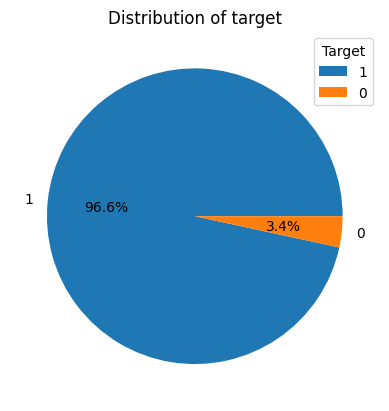

In [156]:
target = df["Target"].value_counts()

plt.pie(target, labels=["1", "0"], autopct='%1.1f%%')
plt.legend(title="Target")
plt.title("Distribution of target")
plt.show()

Vediamo come il dataset risulti essere sbilanciato in favore della classe 1, ovvero la classe che indica che la macchina non si è guastata. Sarà quindi necessario effettuare in seguito un ribilanciamento di esso.

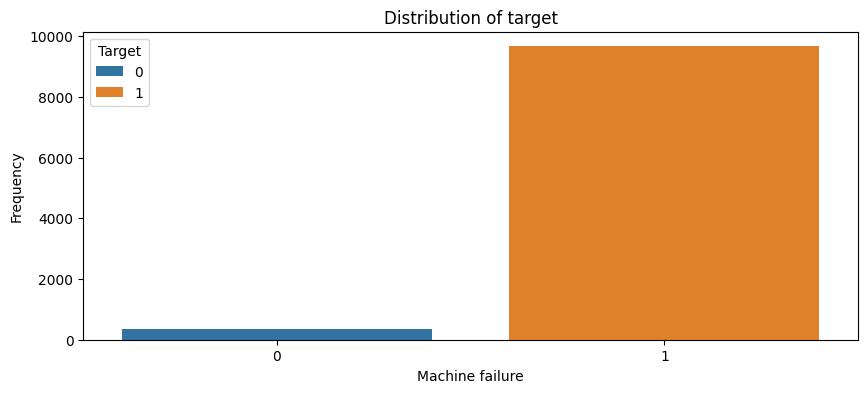

In [157]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Target', data=df, hue='Target')
plt.title("Distribution of target")
plt.xlabel("Machine failure")
plt.ylabel("Frequency")
plt.show()

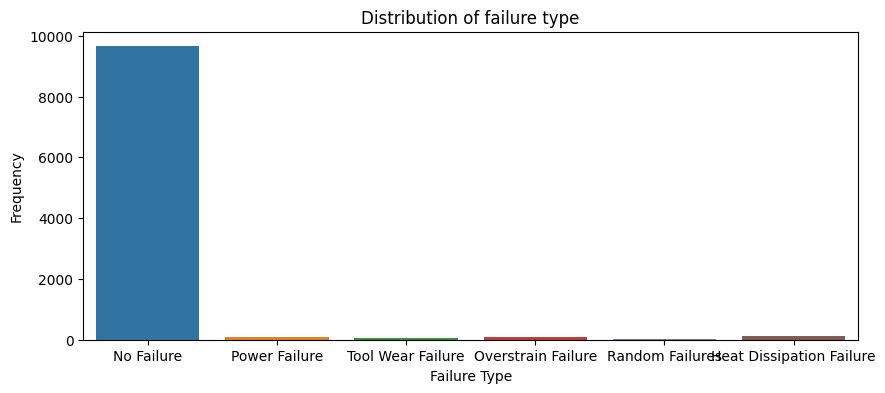

In [158]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Failure Type', data=df, hue='Failure Type')
plt.title("Distribution of failure type")
plt.xlabel("Failure Type")
plt.ylabel("Frequency")
plt.show()

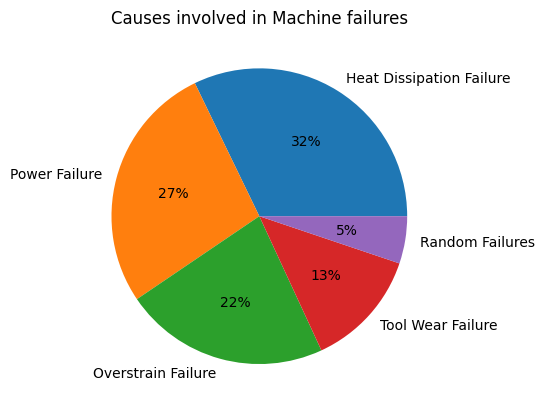

In [159]:
# Seleziona le righe dove 'Failure Type' è diverso da 'No Failure'
df_fail = df[df['Failure Type'] != 'No Failure']

# Calcola la percentuale di ogni tipo di guasto
df_fail_percentage = 100 * df_fail['Failure Type'].value_counts() / len(df_fail)

# Crea il grafico a torta
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.values, labels=df_fail_percentage.index,
        colors=sns.color_palette('tab10')[0:len(df_fail_percentage)], autopct='%.0f%%')
plt.show()

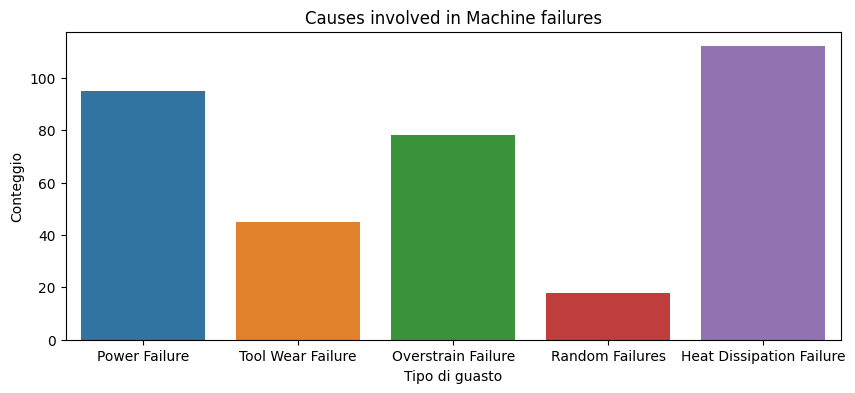

In [160]:
# Crea il countplot
plt.figure(figsize=(10,4))
sns.countplot( x='Failure Type', data=df_fail, hue='Failure Type')
plt.title('Causes involved in Machine failures')
plt.xlabel('Tipo di guasto')
plt.ylabel('Conteggio')
plt.show()

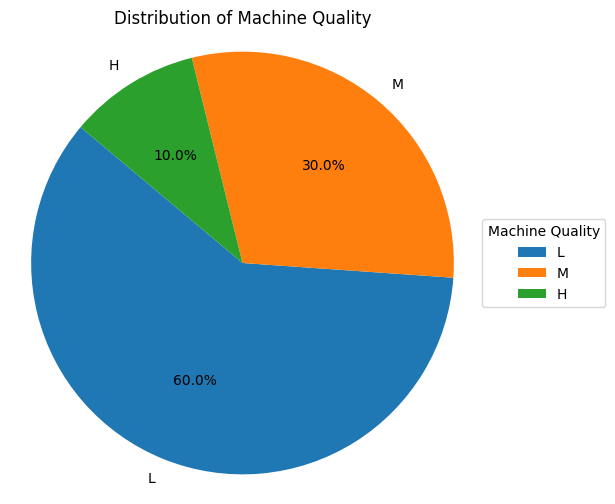

In [161]:
machine_qualities = df['Type'].value_counts()
labels = machine_qualities.index
counts = machine_qualities.values

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Machine Quality')
plt.legend(labels, title="Machine Quality", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()

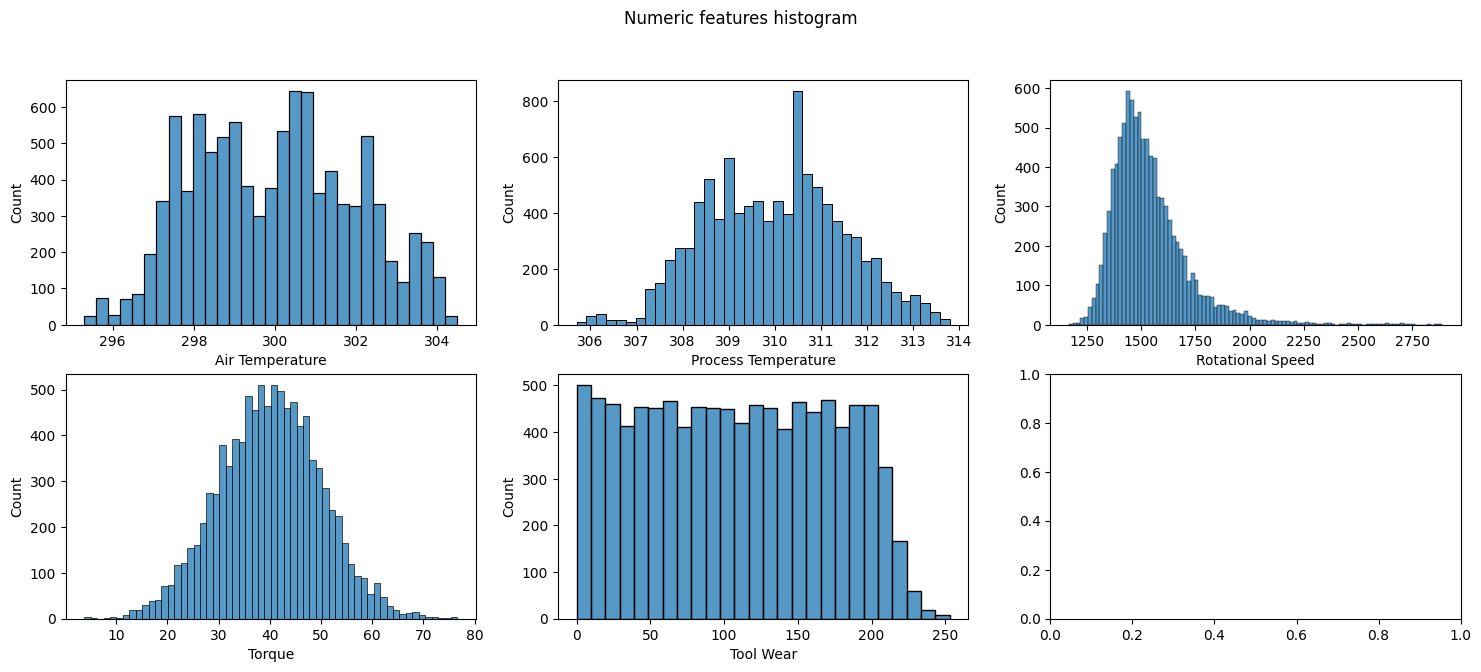

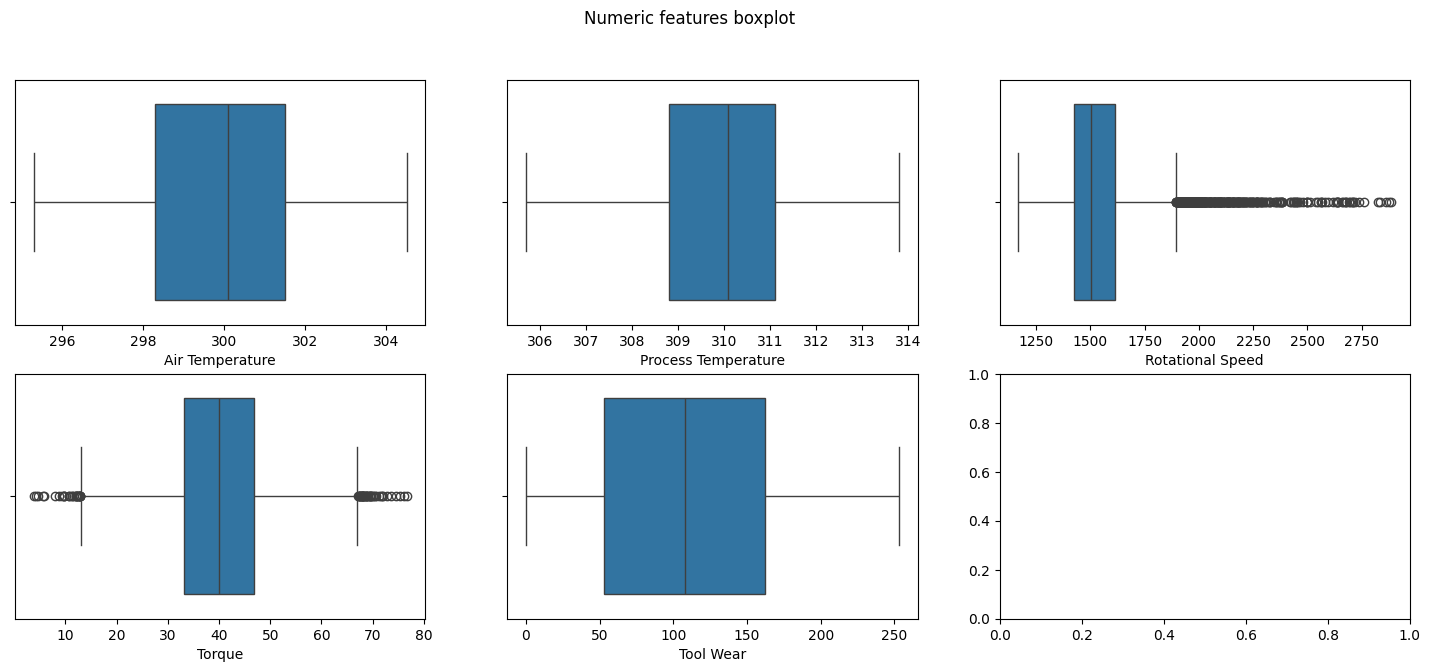

In [162]:
num_features = [feature for feature in df.drop(['Target', 'Type', 'Failure Type'], axis=1)]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axes[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

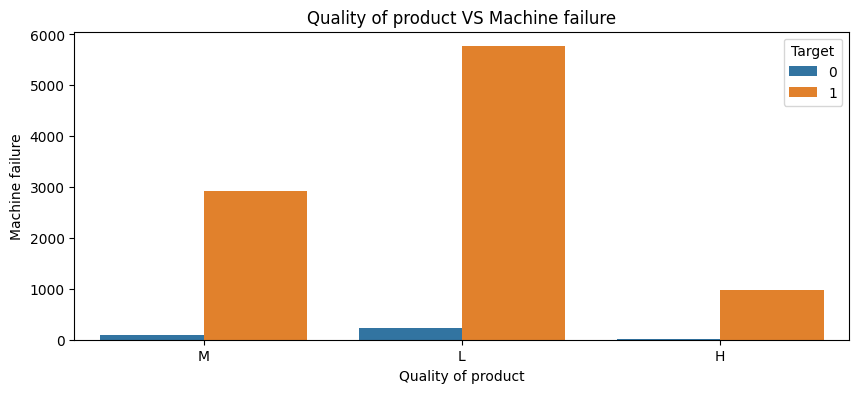

In [163]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Type', hue='Target')
plt.title('Quality of product VS Machine failure')
plt.xlabel('Quality of product')
plt.ylabel('Machine failure')
plt.show()

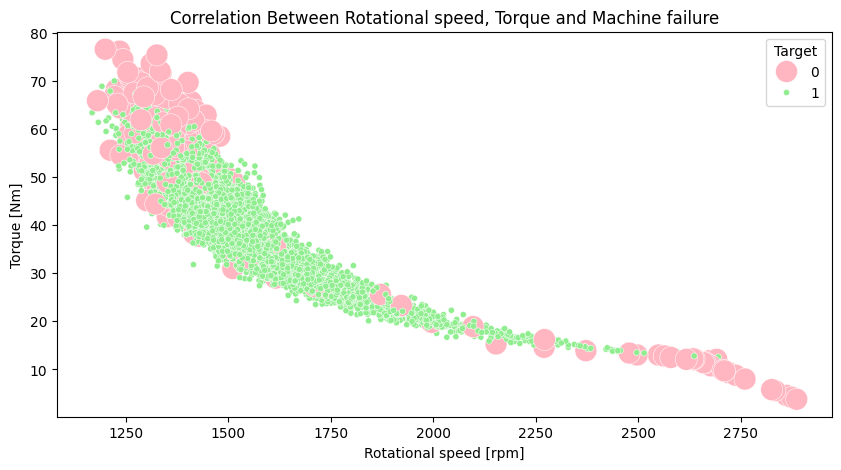

In [164]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Rotational Speed', y='Torque', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(20, 250))
plt.title('Correlation Between Rotational speed, Torque and Machine failure')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()

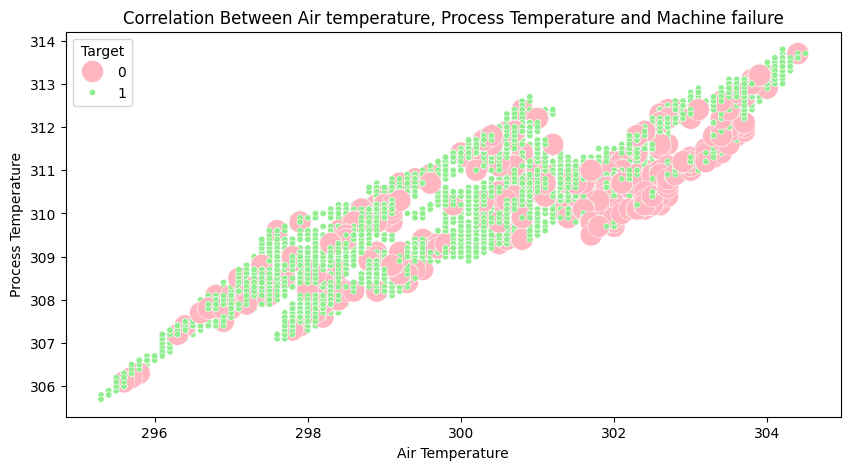

In [165]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Air Temperature', y='Process Temperature', hue='Target', palette=['lightpink', 'lightgreen'], data=df, size='Target', sizes=(20, 250))
plt.title('Correlation Between Air temperature, Process Temperature and Machine failure')
plt.xlabel('Air Temperature')
plt.ylabel('Process Temperature')
plt.show()

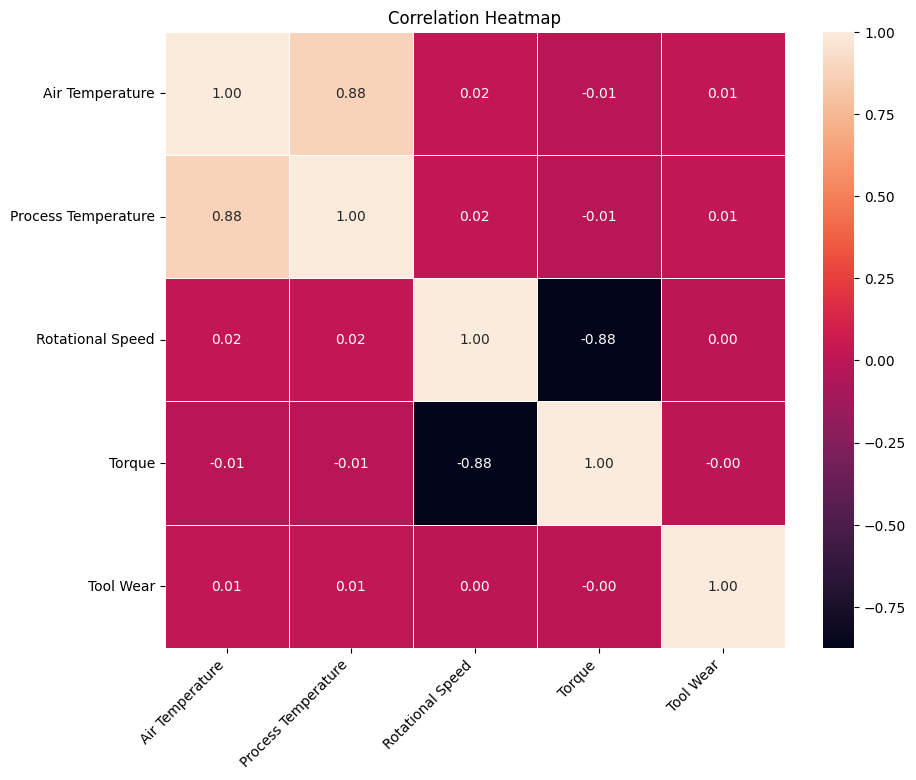

In [166]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

Vediamo dalla matrice di correlazione come le feature siano debolmente correlate tra loro, eccezione fatta per "Air Temperature" e "Process Temperature" che risultano avere una correlazione di 0.88, così come "Rotational Speed" e "Torque" (ma inversa). Possiamo però considerare di introdurre 2 nuove feature rappresentanti una combinazione lineare delle due coppie di feature, ovvero:
- "Temperature Difference" = "Process Temperature" - "Air Temperature"
- "Power" = "a" * "Rotational Speed" * "Torque", con a = 0.104719755

In [167]:
df['Temperature Difference']= df['Process Temperature'] - df['Air Temperature']
df['Power'] = df['Torque'] * df['Rotational Speed'] * 0.104719755

In [168]:
df.head()

Type  Air Temperature  Process Temperature  Rotational Speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool Wear  Target Failure Type  Temperature Difference        Power  
0          0       1   No Failure                    10.5  6951.590552  
1          3       1   No Failure                    10.5  6826.722716  
2          5       1   No Failure                    10.4  7749.387534  
3          7       1   No Failure                    10.4  5927.504652  
4          9       1   No Failure                    10.5  5897.816602

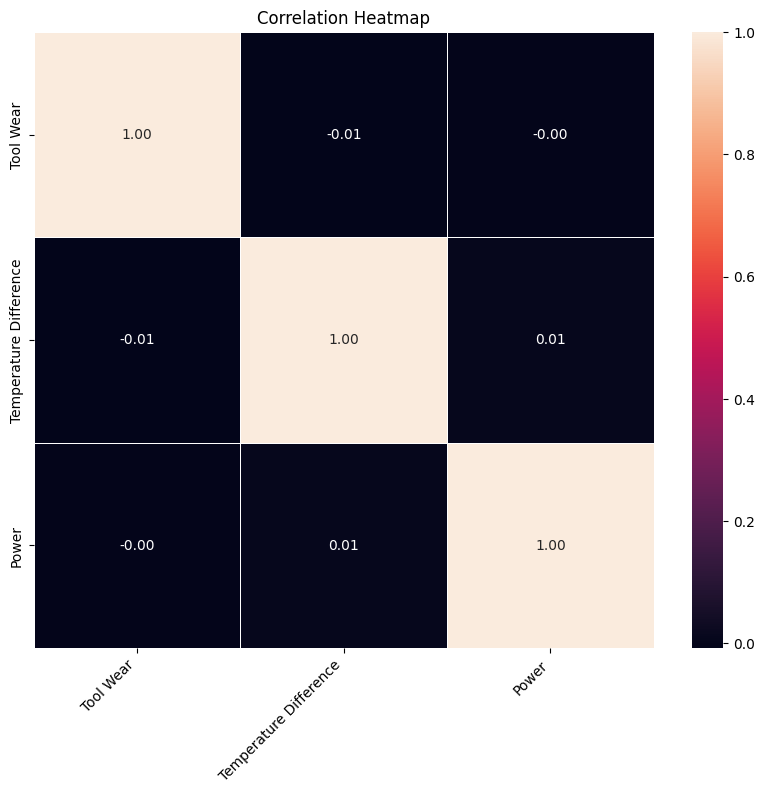

In [169]:
plt.figure(figsize=(10, 8))
heatmap_data = df[['Tool Wear', 'Temperature Difference', 'Power']]
correlation_matrix = heatmap_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

Salviamo quindi il dataset appena modificato:

In [170]:
df.to_csv("dataset.csv", index=False)

## Preparazione dei dati per Predizione Binaria

In [171]:
df = pd.read_csv("dataset.csv")
df = df.drop('Failure Type', axis=1)

Dividiamo il dataset in train e test:

In [172]:
y = df['Target']
X = df.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Come prima cosa andiamo ad usare un Encoder alla feature 'Type' per trasformarla in variabile numerica:

In [173]:
X_train['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

In [174]:
X_test['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

In [175]:
ordinal_feat=[['L'],
              ['M'],
              ['H']
              ]
order = ['L', 'M', 'H']

# Inizializza l'OrdinalEncoder
encoder = OrdinalEncoder(categories= [order])

# Adatta e trasforma i dati con l'OrdinalEncoder
encoded_data = encoder.fit_transform(ordinal_feat)

# Stampa i dati codificati
print(encoded_data)

[[0.]
 [1.]
 [2.]]


Andiamo ad effettuare la mappatura delle etichette per allinearle con i valori nel dataset:

In [176]:
mappatura_etichette = {
    ordinal_feat[0][0]: encoded_data[0][0],
    ordinal_feat[1][0]: encoded_data[1][0],
    ordinal_feat[2][0]: encoded_data[2][0]
}

X_train = X_train.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
X_train['Type'] = X_train['Type'].astype(int)
X_train.head()

X_test = X_test.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
X_test['Type'] = X_test['Type'].astype(int)
X_test.head()

Type  Air Temperature  Process Temperature  Rotational Speed  Torque  \
6252     0            300.8                310.3              1538    36.1   
4684     1            303.6                311.8              1421    44.8   
1731     1            298.3                307.9              1485    42.0   
4742     0            303.3                311.3              1592    33.7   
4521     0            302.4                310.4              1865    23.9   

      Tool Wear  Temperature Difference        Power  
6252        198                     9.5  5814.229293  
4684        101                     8.2  6666.543379  
1731        117                     9.6  6531.371119  
4742         14                     8.0  5618.256744  
4521        129                     8.0  4667.725999

Effettuiamo ora un'operazione di feature selection tramite il metodo chi2

In [177]:
scores, pvalues = chi2(X_train.drop('Type', axis=1), y_train)

print("Punteggi chi2: ", scores)
print("Valori p: ", pvalues)

# Seleziona gli indici delle caratteristiche con un valore p inferiore a 0.05
selected_features = np.where(pvalues < 0.05)[0]
selected_features = [i+1 for i in selected_features]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
y_train_selected= y_train
y_test_selected = y_test

X_train_selected.insert(0, 'Type', X_train['Type'])
X_test_selected.insert(0, 'Type', X_test['Type'])

print("Caratteristiche selezionate: ", selected_features)
X_train_selected

Punteggi chi2:  [8.93777885e-01 1.14059517e-01 2.95703624e+02 7.01475077e+02
 3.35582681e+03 1.08799403e+01 4.22152117e+04]
Valori p:  [3.44455586e-001 7.35568937e-001 2.84334322e-066 1.42869499e-154
 0.00000000e+000 9.72113813e-004 0.00000000e+000]
Caratteristiche selezionate:  [3, 4, 5, 6, 7]


Type  Rotational Speed  Torque  Tool Wear  Temperature Difference  \
9254     0              1616    31.1        195                    10.8   
1561     0              1388    53.8        137                    10.2   
1670     0              1528    31.1        194                     9.6   
6087     1              1599    33.0          7                     9.9   
6669     0              1571    33.9        208                     9.1   
...    ...               ...     ...        ...                     ...   
5734     0              1369    56.2        208                     9.5   
5191     0              1416    46.0        128                     9.2   
5390     2              1483    47.2        223                     9.5   
860      2              1541    32.6         33                    10.8   
7270     0              1808    25.8         35                    10.2   

            Power  
9254  5262.963559  
1561  7819.884873  
1670  4976.366533  
6087  5525.747312  
6669  5577.049520  
...           ...  
5734  8056.907566  
5191  6821.025962  
5390  7330.131523  
860   5260.764444  
7270  4884.799580  

[8000 rows x 6 columns]

Andiamo ora ad effettuare il resampling del nostro training set. Per farlo useremo il modello SMOTEENN, modello che combina le tecniche di oversampling e di undersampling utilizzando SMOTE e Edited Nearest Neighbour (ENN)"

In [178]:
print("Prima del resampling:")
print(y_train.value_counts())

print("\n")

smenn = SMOTEENN(random_state=42)
X_train, y_train = smenn.fit_resample(X_train, y_train)

print("Dopo il resampling:")
print(y_train.value_counts())

Prima del resampling:
Target
1    7722
0     278
Name: count, dtype: int64


Dopo il resampling:
Target
0    7106
1    6637
Name: count, dtype: int64


In [179]:
print("Prima del resampling:")
print(y_train_selected.value_counts())

print("\n")

smenn = SMOTEENN(random_state=2)
X_train_selected, y_train_selected = smenn.fit_resample(X_train_selected, y_train_selected)

print("Dopo il resampling:")
print(y_train_selected.value_counts())

Prima del resampling:
Target
1    7722
0     278
Name: count, dtype: int64


Dopo il resampling:
Target
0    7053
1    6645
Name: count, dtype: int64


Scaliamo i dati:

In [180]:
features_to_scale = ['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear', 'Temperature Difference', 'Power']

scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [181]:
features_to_scale = ['Rotational Speed', 'Torque', 'Tool Wear', 'Temperature Difference', 'Power']

scaler = StandardScaler()
X_train_selected[features_to_scale] = scaler.fit_transform(X_train_selected[features_to_scale])
X_test_selected[features_to_scale] = scaler.transform(X_test_selected[features_to_scale])

C:\Users\david\AppData\Local\Temp\ipykernel_9684\2704878987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_selected[features_to_scale] = scaler.transform(X_test_selected[features_to_scale])


I modelli saranno allenati con 2 diverse configurazioni dei dati di train, ovvero:
- Con le feature originali, ovvero 'Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear' e 'Type'
- Con le feature create, ovvero 'Temperature Difference', 'Power', 'Tool Wear' e 'Type'

In [182]:
X_train_original = X_train.drop(['Temperature Difference', 'Power'], axis=1)
X_test_original = X_test.drop(['Temperature Difference', 'Power'], axis=1)

selected_feature = ['Type', 'Tool Wear', 'Temperature Difference', 'Power']
X_train_modified = X_train[selected_feature]
X_test_modified = X_test[selected_feature]

In [183]:
X_train

Type  Air Temperature  Process Temperature  Rotational Speed    Torque  \
0         0        -1.070156            -1.423381         -0.289878  1.191668   
1         2         0.791447            -0.278506         -0.791688  0.846409   
2         0        -0.656467             0.408419          0.707182 -1.245860   
3         1         1.308559             0.713719         -0.489946  0.639253   
4         1         0.532891             0.179444          3.665564 -2.281636   
...     ...              ...                  ...               ...       ...   
13738     0        -1.690691            -1.270731          0.093859 -0.244609   
13739     0         1.825671             2.316544         -0.345635  0.066124   
13740     2         1.205136             1.629619         -0.125888  0.148986   
13741     2        -2.259514            -2.491931          0.064341 -0.859170   
13742     0        -0.139355             0.179444          0.940048 -1.328722   

       Tool Wear  Temperature Difference     Power  
0      -1.513171                0.192120  1.610564  
1       0.360050               -1.779866  0.561418  
2       1.510531                1.694586 -1.180035  
3      -0.082443               -1.498154  0.637517  
4      -1.498421               -0.746921 -2.183025  
...          ...                     ...       ...  
13738   0.035555                1.506778 -0.032500  
13739   0.079804               -0.465209  0.020906  
13740   1.481032               -0.183496  0.341052  
13741  -1.321424                1.037257 -0.960248  
13742  -1.291924                0.473832 -1.196669  

[13743 rows x 8 columns]

## Addestramento dei Modelli

Definiamo prima di tutto una funzione che raccoglie tutte le principali metriche di valutazione che andremo ad utilizare per i modelli che saranno allenati:

In [184]:
def prediction_evaluation(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_wg = precision_score(y_test, y_pred, average='weighted')
    recall_wg = recall_score(y_test, y_pred, average='weighted')
    f1_wg = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    print("Accuracy: %0.5f" % (accuracy))
    print("Balanced Accuracy: %0.5f" % (bal_acc))
    print("MCC: %0.5f" % (mcc))
    print("Precision: %0.5f" % (precision))
    print("Recall: %0.5f" % (recall))
    print("F1: %0.5f" % (f1))
    print("Precision weighted: %0.5f" % (precision_wg))
    print("Recall weighted: %0.5f" % (recall_wg))
    print("F1 weighted: %0.5f" % (f1_wg))
    print("ROC AUC: %0.5f" % (roc_auc))
    # Estrazione dei valori dalla matrice di confusione
    TP, FP, FN, TN = conf_matrix.ravel()

    specificity = TN / (TN + FP)
    print("Specificità: %0.5f" % (specificity))

    print("Precision negativa: %0.5f" % (TN/(TN+FN)))

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.title('Confusion Matrix')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)


    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

### Binary DecisionTree


I Decision Tree sono modelli di apprendimento automatico utilizzati sia per problemi di classificazione che di regressione. Operano dividendo ripetutamente il dataset in sottoinsiemi omogenei in base alle caratteristiche dei dati, fino a quando non viene raggiunta una condizione di stop predefinita. Due caratteristiche principali degli alberi decisionali sono la versatilità e la semplicità.
Andiamo quindi ad addestrare un modello di Decision Tree:

Usiamo ora il dataset originale:

Accuracy: 0.93500
Balanced Accuracy: 0.86327
MCC: 0.45410
Precision: 0.99292
Recall: 0.93966
F1: 0.96555
Precision weighted: 0.97150
Recall weighted: 0.93500
F1 weighted: 0.94906
ROC AUC: 0.86327
Specificità: 0.99292
Precision negativa: 0.93966


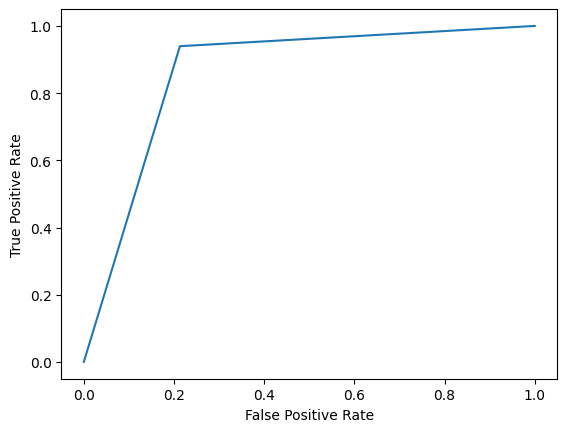

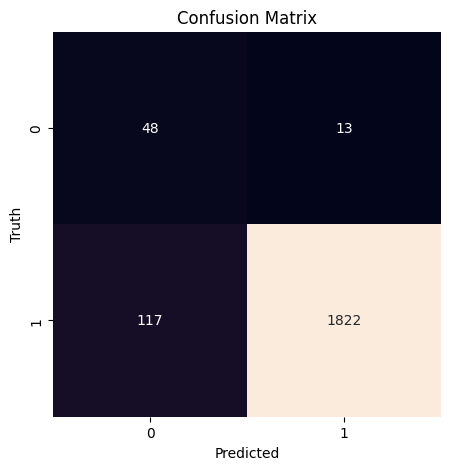

Tempo di addestramento 0.25837230682373047


In [191]:
clf = DecisionTreeClassifier(criterion="gini")

start = time.time()
clf.fit(X_train_original, y_train)
end = time.time()

y_pred = clf.predict(X_test_original)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento", end-start)

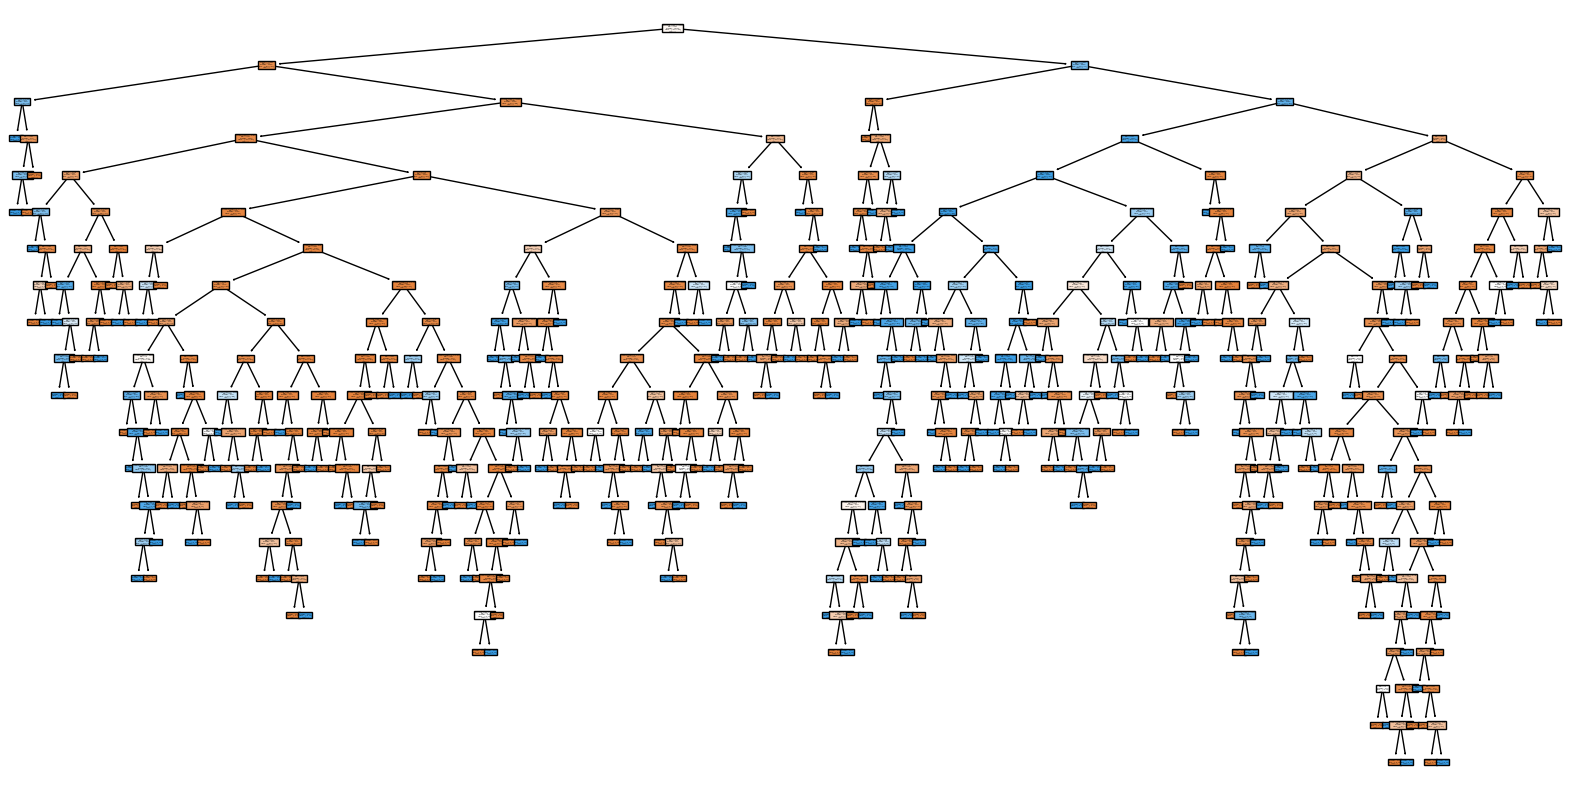

In [192]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_original.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning


Il pruning dell'albero è una tecnica di Machine Learning utilizzata per ottimizzare i modelli di albero di decisione riducendo l'overfitting e migliorando la generalizzazione a nuovi dati. Per il nostro caso utilizzeremo la tecninca di post-pruning.
Il post-pruning comporta la rimozione di rami o nodi per migliorare la capacità del modello di generalizzare. In particolare verrà applicato il metodo CPP (Cost-Complexity Pruning), metodo che assegna un valore a ciascun sottoalbero principalmente in base alla sua accuratezza e complessità, quindi seleziona il sottoalbero con il costo più basso.

In [194]:
path=clf.cost_complexity_pruning_path(X_train_original, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [195]:
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train_original, y_train)
    pruned_models.append(pruned_model)

best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test_original, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model

accuracy_after_pruning = best_pruned_model.score(X_test_original, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.937


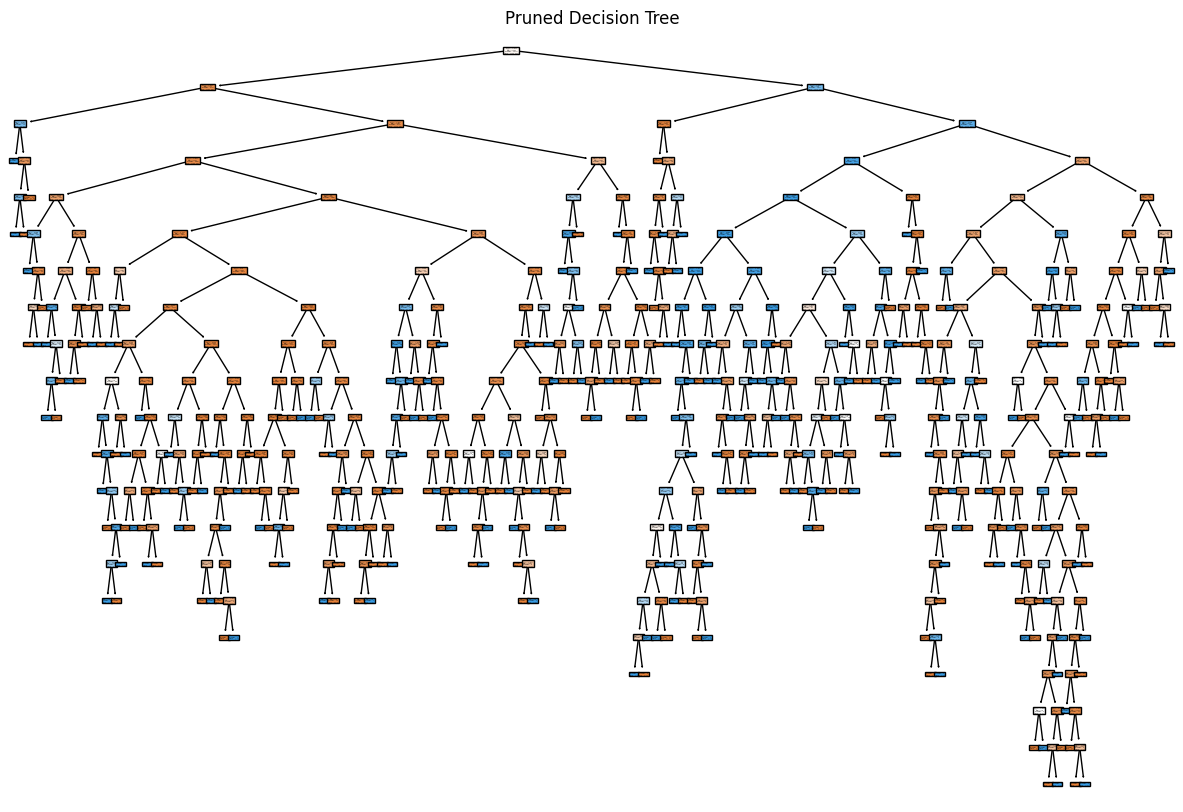

In [196]:
# Plot pruned tree
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

Alleniamo ora un nuovo modello con il dataset in cui abbiamo aggiunto le nuove feature:

Accuracy: 0.92050
Balanced Accuracy: 0.79228
MCC: 0.35302
Precision: 0.98847
Recall: 0.92883
F1: 0.95772
Precision weighted: 0.96518
Recall weighted: 0.92050
F1 weighted: 0.93872
ROC AUC: 0.79228
Specificità: 0.98847
Precision negativa: 0.92883


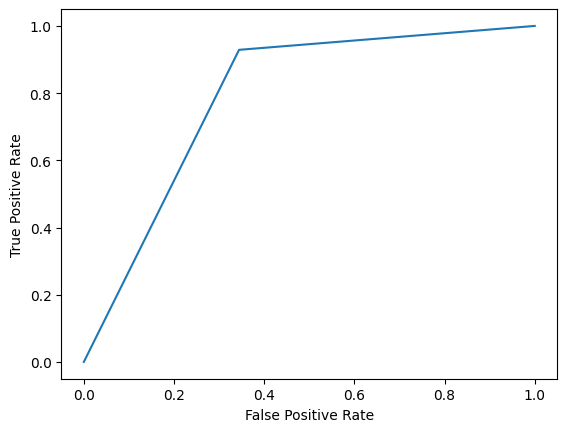

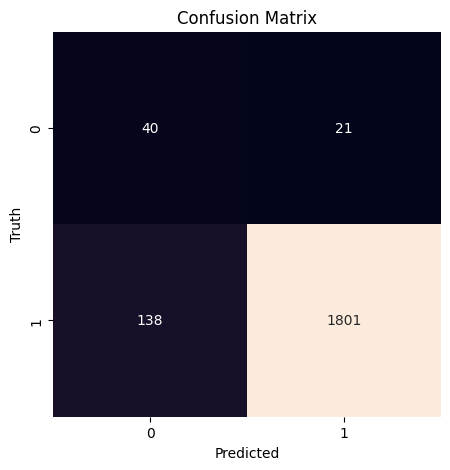

Tempo di addestramento: 0.19315528869628906


In [197]:
clf = DecisionTreeClassifier(criterion="gini")

start = time.time()
clf.fit(X_train_modified, y_train)
end = time.time()

y_pred = clf.predict(X_test_modified)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

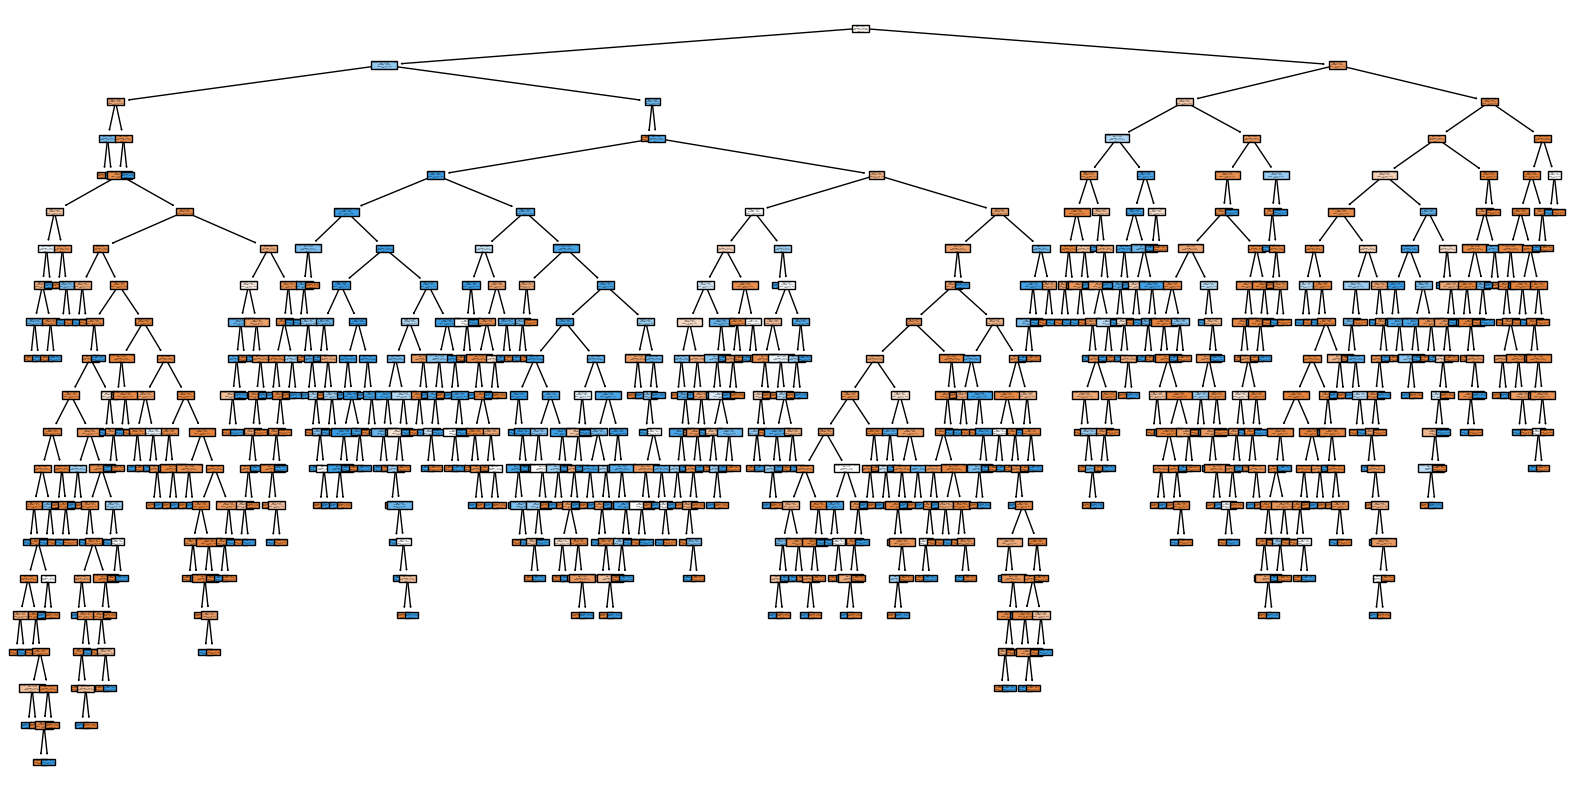

In [198]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_modified.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning

In [200]:
path=clf.cost_complexity_pruning_path(X_train_modified, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [201]:
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train_modified, y_train)
    pruned_models.append(pruned_model)

best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test_modified, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model

accuracy_after_pruning = best_pruned_model.score(X_test_modified, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.9245


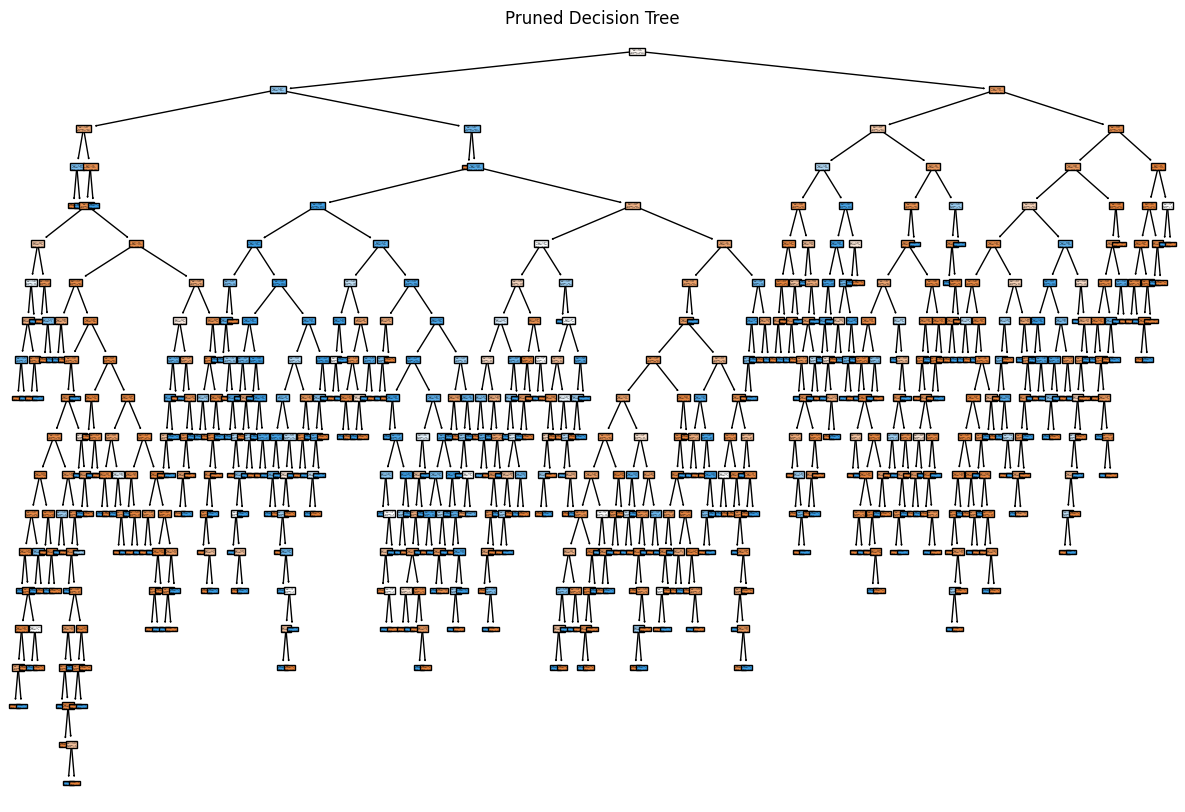

In [202]:
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

Alleniamo il modello con il dataset completo (incluse le feature introdotte in seguito):

Accuracy: 0.93700
Balanced Accuracy: 0.84843
MCC: 0.44554
Precision: 0.99186
Recall: 0.94275
F1: 0.96668
Precision weighted: 0.97055
Recall weighted: 0.93700
F1 weighted: 0.95007
ROC AUC: 0.84843
Specificità: 0.99186
Precision negativa: 0.94275


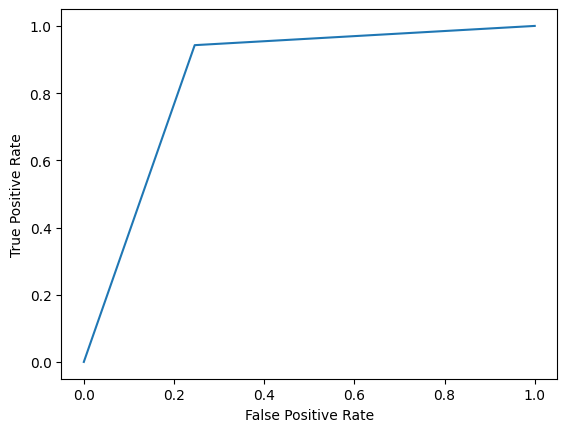

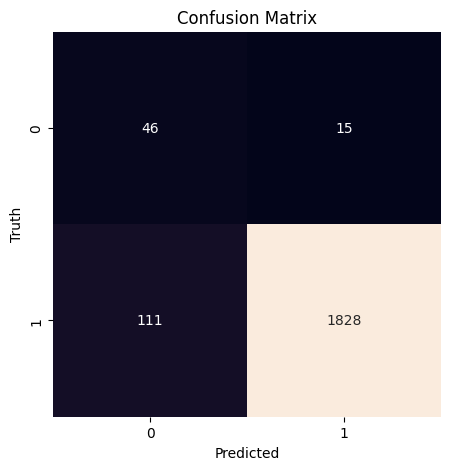

Tempo di addestramento: 0.3136277198791504


In [ ]:
clf = DecisionTreeClassifier(criterion="gini")

start = time.time()
clf.fit(X_train, y_train)
end = time.time()

y_pred = clf.predict(X_test)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

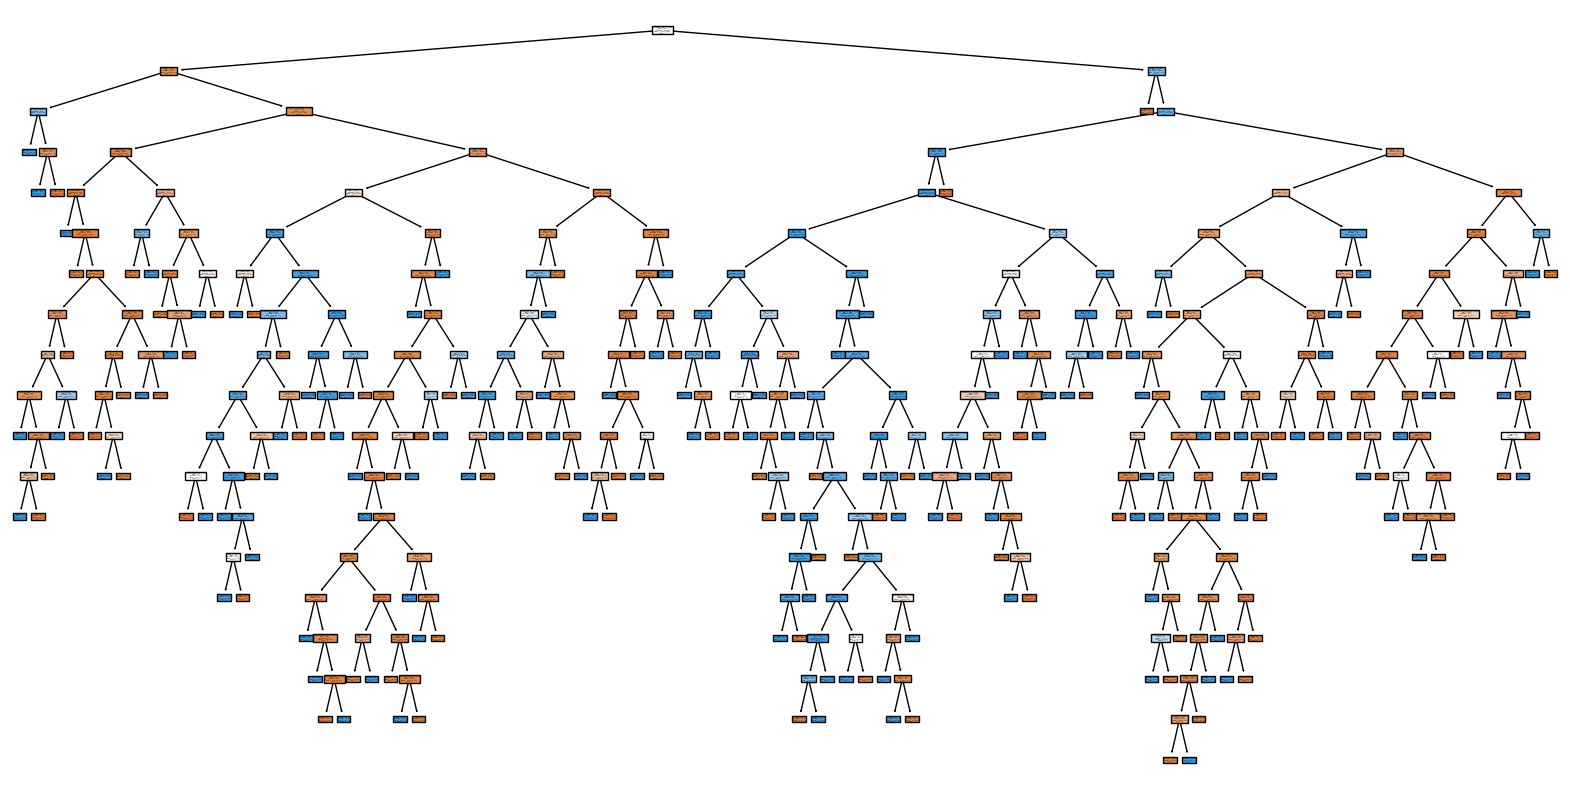

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning

In [ ]:
path=clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train, y_train)
    pruned_models.append(pruned_model)

best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model

accuracy_after_pruning = best_pruned_model.score(X_test, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.939


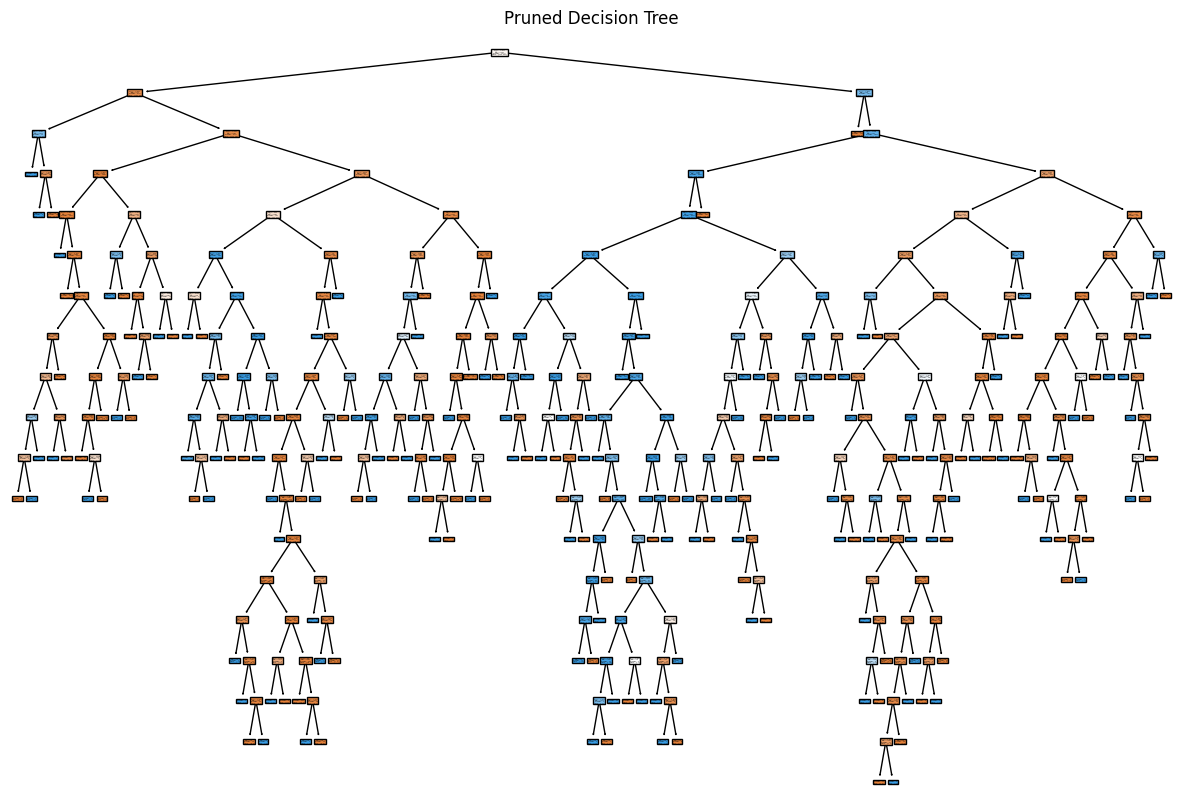

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

Come ultimo test alleneremo un modello con i dati selezionati dal test chi2:

Accuracy: 0.93800
Balanced Accuracy: 0.86482
MCC: 0.46381
Precision: 0.99294
Recall: 0.94275
F1: 0.96720
Precision weighted: 0.97186
Recall weighted: 0.93800
F1 weighted: 0.95101
ROC AUC: 0.86482
Specificità: 0.99294
Precision negativa: 0.94275


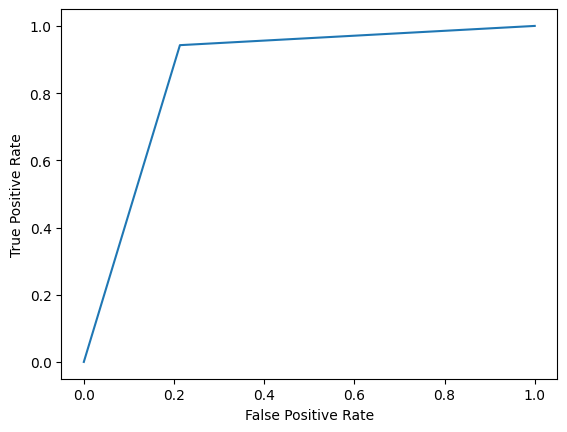

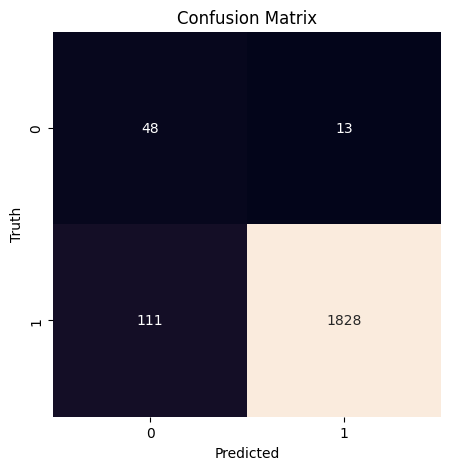

Tempo di addestramento: 0.15699410438537598


In [203]:
clf = DecisionTreeClassifier(criterion="gini")

start = time.time()
clf.fit(X_train_selected, y_train_selected)
end = time.time()

y_pred = clf.predict(X_test_selected)

prediction_evaluation(y_test_selected, y_pred)
print("Tempo di addestramento:", end-start)

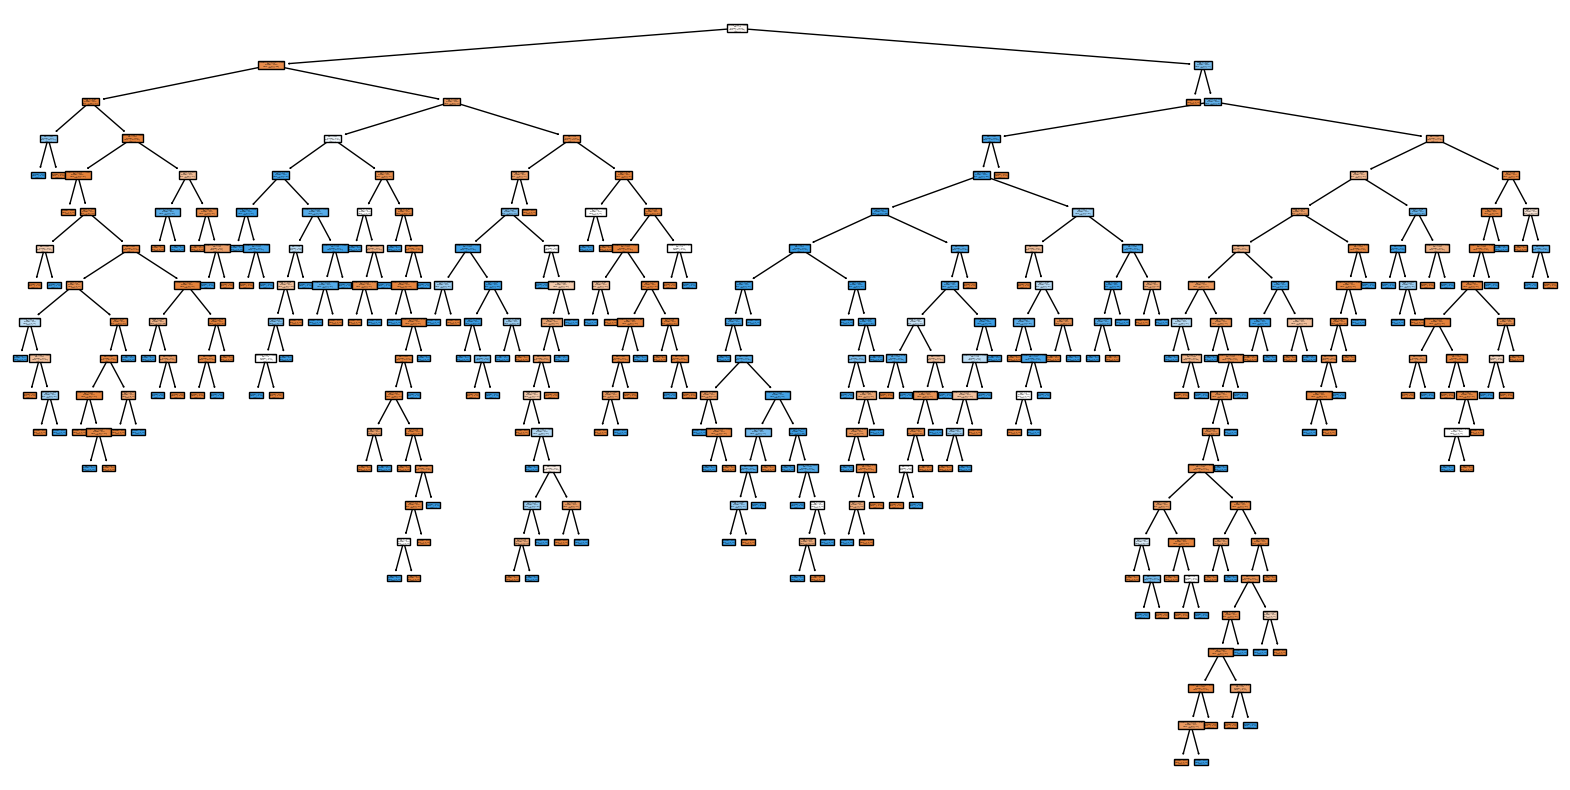

In [204]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_selected.columns, class_names=['0','1'], proportion=True)
plt.show()

#### Fine Tuning

In [206]:
path=clf.cost_complexity_pruning_path(X_train_selected, y_train_selected)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [207]:
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train_selected, y_train_selected)
    pruned_models.append(pruned_model)

best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test_selected, y_test_selected)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model

accuracy_after_pruning = best_pruned_model.score(X_test_selected, y_test_selected)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.9415


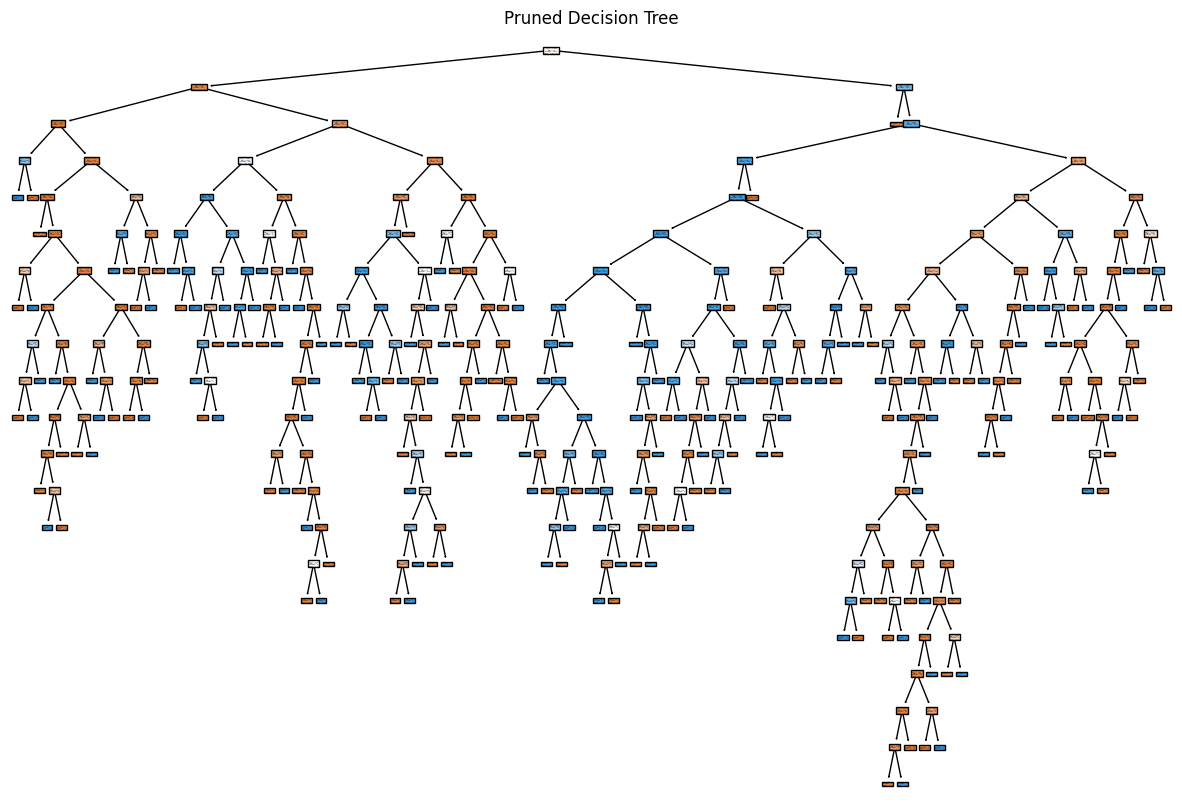

In [208]:
plt.figure(figsize=(15, 10))
plot_tree(best_pruned_model, filled=True)
plt.title("Pruned Decision Tree")
plt.show()

### Binary SVM

Le SVM (Support Vector Machines) sono un algoritmo di apprendimento supervisionato utilizzato sia per problemi di classificazione che di regressione. Le SVM sono potenti strumenti di classificazione che si distinguono per la loro capacità di trovare iperpiani di decisione ottimali che massimizzano il margine tra le classi e per la loro flessibilità nell'affrontare problemi complessi tramite il kernel trick.

Alleniamo ora il modello con il dataset originale:

Accuracy: 0.90450
Balanced Accuracy: 0.87136
MCC: 0.39883
Precision: 0.99434
Recall: 0.90665
F1: 0.94848
Precision weighted: 0.97072
Recall weighted: 0.90450
F1 weighted: 0.93017
ROC AUC: 0.87136
Specificità: 0.99434
Precision negativa: 0.90665


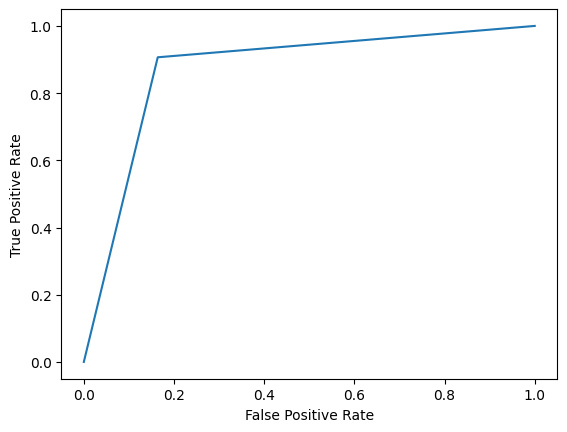

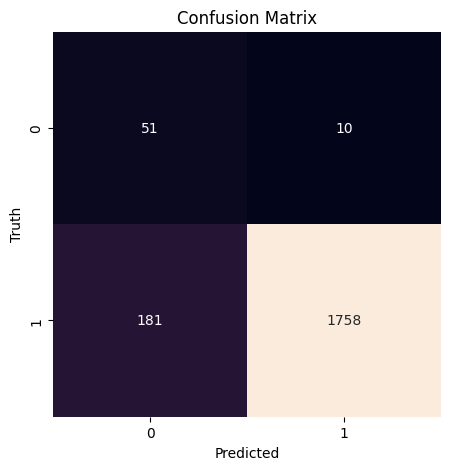

Tempo di addestramento: 1.4026644229888916


In [219]:
svm = SVC()

start = time.time()
svm.fit(X_train_original, y_train)
end = time.time()

y_pred = svm.predict(X_test_original)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

#### Fine Tuning


Il fine tuning di un modello SVM può essere fatto regolando i suoi parametri per trovare la loro combinazione migliore; in particolare analizzeremo i seguenti parametri:
- C: Questo parametro controlla il compromesso tra ottenere il margine più ampio possibile e minimizzare il tasso di classificazione errata.
- gamma: Questo parametro controlla quanto influisce un singolo esempio di addestramento.
- kernel: Questo parametro controlla il tipo di iperpiano utilizzato per separare i dati.

In [221]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_original, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.6s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy: 0.94000
Balanced Accuracy: 0.83410
MCC: 0.44031
Precision: 0.99083
Recall: 0.94688
F1: 0.96835
Precision weighted: 0.96973
Recall weighted: 0.94000
F1 weighted: 0.95172
ROC AUC: 0.83410
Specificità: 0.99083
Precision negativa: 0.94688


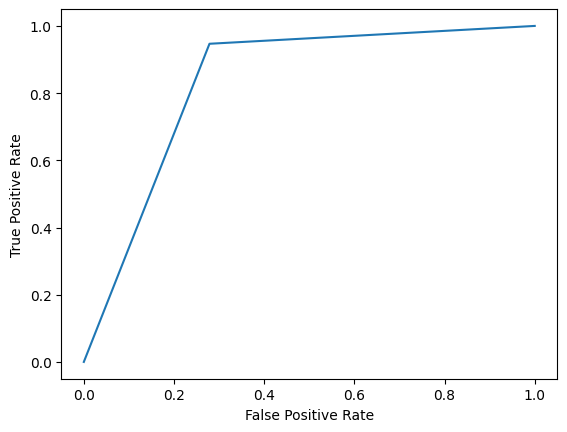

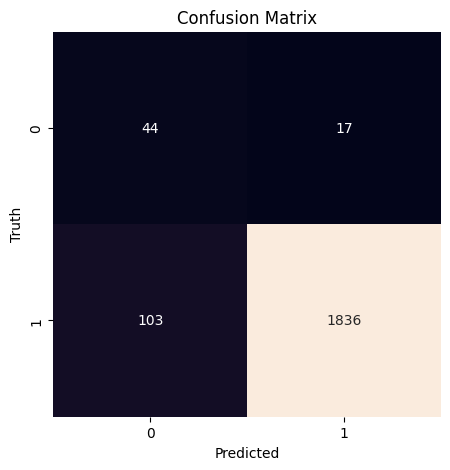

Tempo di addestramento: 2.785682439804077


In [222]:
svm = SVC(**grid.best_params_)

start = time.time()
svm.fit(X_train_original, y_train)
end = time.time()

y_pred = svm.predict(X_test_original)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

Usiamo ora il dataset modificato:

Accuracy: 0.87600
Balanced Accuracy: 0.88048
MCC: 0.36901
Precision: 0.99589
Recall: 0.87571
F1: 0.93194
Precision weighted: 0.97110
Recall weighted: 0.87600
F1 weighted: 0.91277
ROC AUC: 0.88048
Specificità: 0.99589
Precision negativa: 0.87571


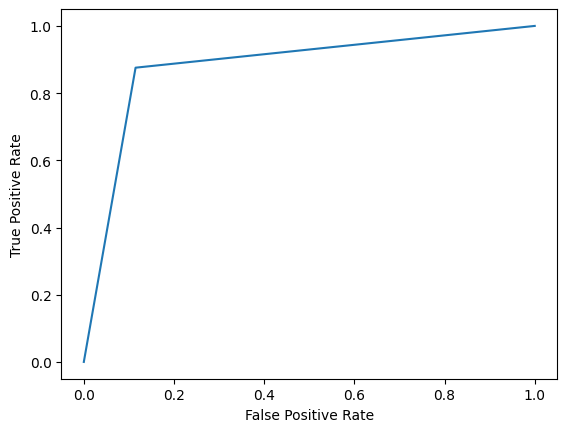

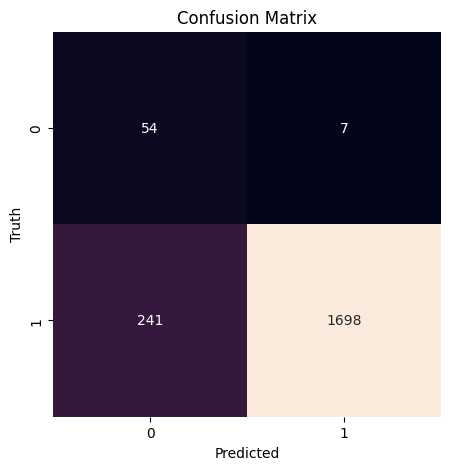

Tempo di addestramento: 3.382175922393799


In [224]:
svm = SVC()

start = time.time()
svm.fit(X_train_modified, y_train)
end = time.time()

y_pred = svm.predict(X_test_modified)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

#### Fine Tuning

In [226]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_modified, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.7s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy: 0.89850
Balanced Accuracy: 0.85239
MCC: 0.37294
Precision: 0.99318
Recall: 0.90150
F1: 0.94512
Precision weighted: 0.96912
Recall weighted: 0.89850
F1 weighted: 0.92622
ROC AUC: 0.85239
Specificità: 0.99318
Precision negativa: 0.90150


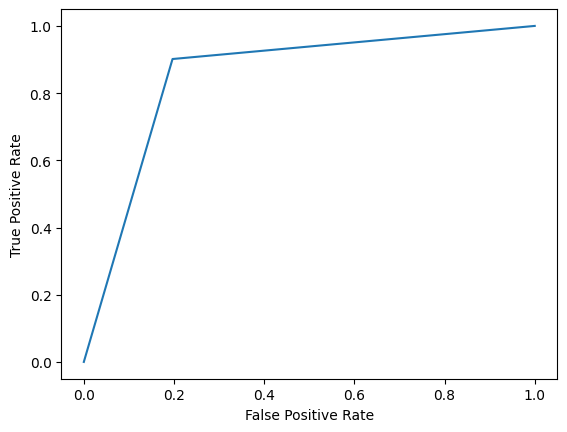

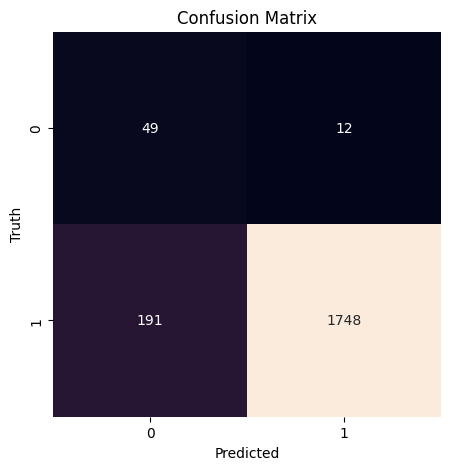

Tempo di addestramento: 2.4510042667388916


In [227]:
svm = SVC(**grid.best_params_)

start = time.time()
svm.fit(X_train_modified, y_train)
end = time.time()

y_pred = svm.predict(X_test_modified)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

Vediamo ora con il dataset completo:

Accuracy: 0.91350
Balanced Accuracy: 0.86806
MCC: 0.41120
Precision: 0.99385
Recall: 0.91645
F1: 0.95358
Precision weighted: 0.97073
Recall weighted: 0.91350
F1 weighted: 0.93567
ROC AUC: 0.86806
Specificità: 0.99385
Precision negativa: 0.91645


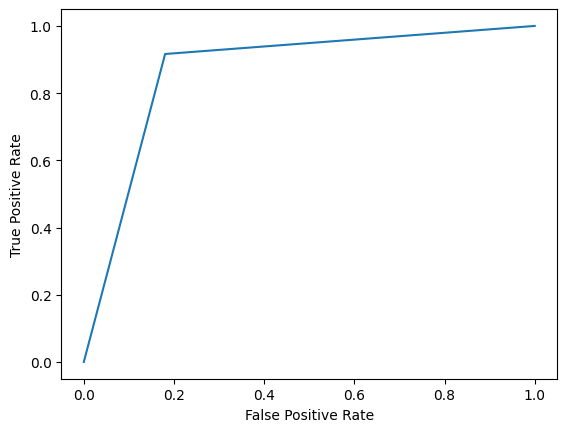

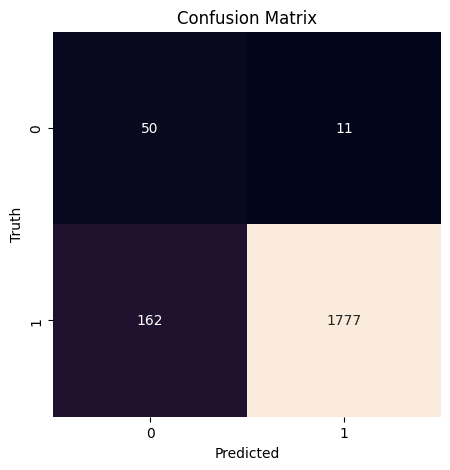

Tempo di addestramento: 2.339625358581543


In [ ]:
svm = SVC()

start = time.time()
svm.fit(X_train, y_train)
end = time.time()

y_pred = svm.predict(X_test)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

#### Fine Tuning

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   8.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   9.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   4.8s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy: 0.94700
Balanced Accuracy: 0.82977
MCC: 0.45841
Precision: 0.99037
Recall: 0.95462
F1: 0.97216
Precision weighted: 0.97017
Recall weighted: 0.94700
F1 weighted: 0.95617
ROC AUC: 0.82977
Specificità: 0.99037
Precision negativa: 0.95462


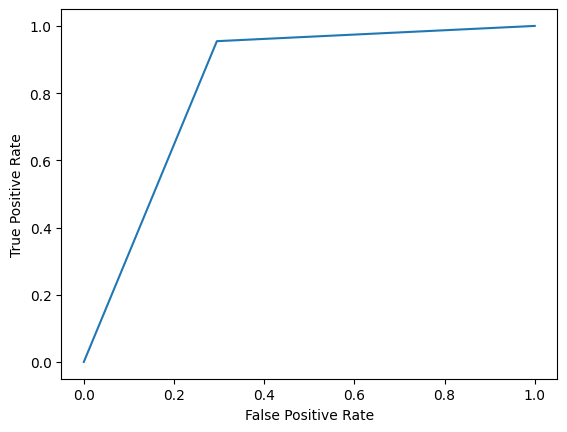

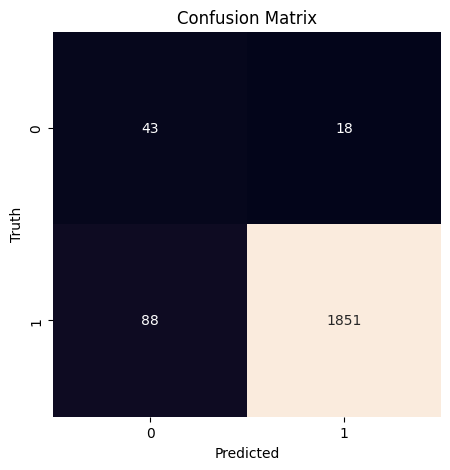

Tempo di addestramento: 1.4857728481292725


In [ ]:
svm = SVC(**grid.best_params_)

start = time.time()
svm.fit(X_train, y_train)
end = time.time()

y_pred = svm.predict(X_test)

prediction_evaluation(y_test, y_pred)
print("Tempo di addestramento:", end-start)

Come ultimo test vediamo un modello allenato con il dataset ottenuto con feature selection

Accuracy: 0.90650
Balanced Accuracy: 0.88827
MCC: 0.41699
Precision: 0.99548
Recall: 0.90768
F1: 0.94955
Precision weighted: 0.97208
Recall weighted: 0.90650
F1 weighted: 0.93163
ROC AUC: 0.88827
Specificità: 0.99548
Precision negativa: 0.90768


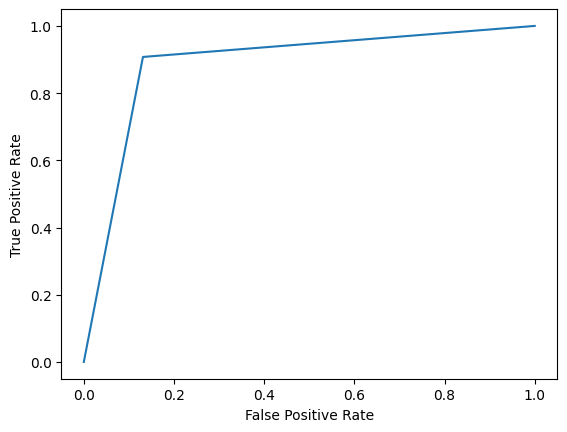

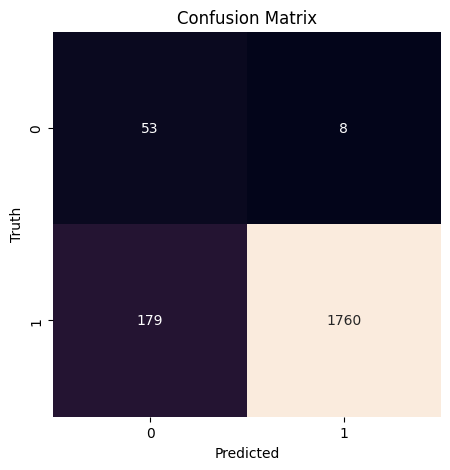

Tempo di addestramento: 1.9322421550750732


In [ ]:
svm = SVC()

start = time.time()
svm.fit(X_train_selected, y_train_selected)
end = time.time()

y_pred = svm.predict(X_test_selected)

prediction_evaluation(y_test_selected, y_pred)
print("Tempo di addestramento:", end-start)

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_selected, y_train_selected)

print(grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   2.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   2.3s
[CV] END ....................C=0.1, gamma=0.1, 

Accuracy: 0.93200
Balanced Accuracy: 0.83791
MCC: 0.42240
Precision: 0.99128
Recall: 0.93811
F1: 0.96396
Precision weighted: 0.96936
Recall weighted: 0.93200
F1 weighted: 0.94671
ROC AUC: 0.83791
Specificità: 0.99128
Precision negativa: 0.93811


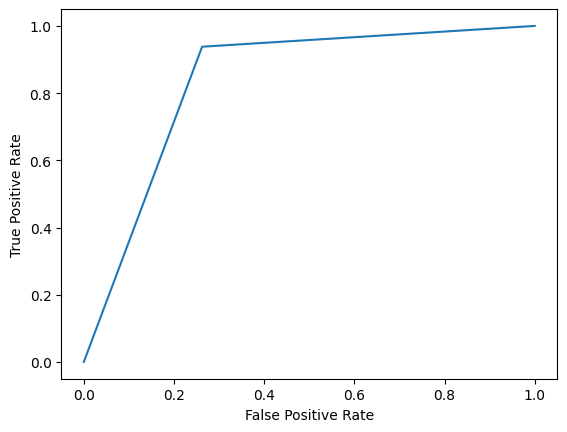

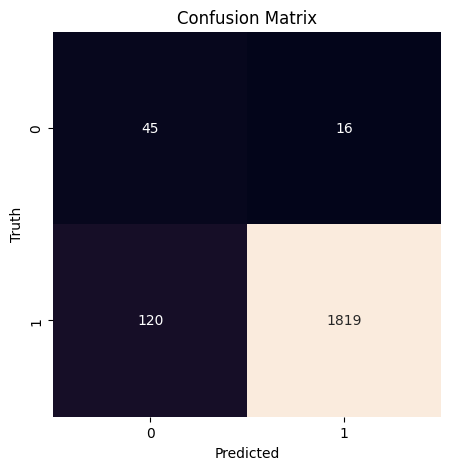

Tempo di addestramento: 2.66438889503479


In [ ]:
svm = SVC(**grid.best_params_)

start = time.time()
svm.fit(X_train_selected, y_train_selected)
end = time.time()

y_pred = svm.predict(X_test_selected)

prediction_evaluation(y_test_selected, y_pred)
print("Tempo di addestramento:", end-start)

## Preparazione dei dati per Predizione Multivariata

In [229]:
df = pd.read_csv("dataset.csv")
df = df.drop('Target', axis=1)
df = df.rename(columns={'Failure Type': 'Target'})

In [230]:
mask = df['Target'] != 'No Failure'
df = df[mask]

Dividiamo il dataset in train e test:

In [231]:
y = df['Target']
X = df.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Come prima cosa andiamo ad usare un Encoder alla feature 'Type' per trasformarla in variabile numerica:

In [232]:
X_test['Type'].unique()

array(['M', 'L', 'H'], dtype=object)

In [233]:
ordinal_feat=[['M'],
              ['L'],
              ['H']
              ]
order = ['L', 'M', 'H']

# Inizializza l'OrdinalEncoder
encoder = OrdinalEncoder(categories= [order])

# Adatta e trasforma i dati con l'OrdinalEncoder
encoded_data = encoder.fit_transform(ordinal_feat)

# Stampa i dati codificati
print(encoded_data)

[[1.]
 [0.]
 [2.]]


In questo caso non è necessario effettuare la mappatura delle etichette, in quanto già allineate.

In [234]:
mappatura_etichette = {
    ordinal_feat[0][0]: encoded_data[0][0],
    ordinal_feat[1][0]: encoded_data[1][0],
    ordinal_feat[2][0]: encoded_data[2][0]
}

X_train = X_train.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
X_train['Type'] = X_train['Type'].astype(int)
X_train.head()

X_test = X_test.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
X_test['Type'] = X_test['Type'].astype(int)
X_test.head()

Type  Air Temperature  Process Temperature  Rotational Speed  Torque  \
5615     1            303.0                312.2              1257    71.3   
4081     0            302.0                310.4              1336    58.2   
8195     0            299.4                310.8              1376    53.9   
6178     0            301.1                310.9              1282    67.9   
4409     1            302.4                310.1              1358    54.6   

      Tool Wear  Temperature Difference        Power  
5615        122                     9.2  9385.413794  
4081        110                     8.4  8142.505494  
8195        215                    11.4  7766.687237  
6178         10                     9.8  9115.624289  
4409         61                     7.7  7764.634730

Ora è necessario invece effettuare l'encoding del target usando un LabelEncoder:

In [235]:
encoder = LabelEncoder()

# Addestra il LabelEncoder e trasforma le etichette di addestramento
y_train_temp = encoder.fit_transform(y_train)

# Trasforma le etichette di test
y_test_temp = encoder.transform(y_test)

y_train = pd.Series(y_train_temp, index=y_train.index, name=y_train.name)
y_test = pd.Series(y_test_temp, index=y_test.index, name=y_test.name)

In [236]:
X_train.shape

(278, 8)

In [237]:
scores, pvalues = chi2(X_train.drop('Type', axis=1), y_train)

print("Punteggi chi2: ", scores)
print("Valori p: ", pvalues)

selected_features = np.where(pvalues < 0.05)[0]
selected_features = [i+1 for i in selected_features]

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
y_train_selected= y_train
y_test_selected = y_test

X_train_selected.insert(0, 'Type', X_train['Type'])
X_test_selected.insert(0, 'Type', X_test['Type'])

print("Caratteristiche selezionate: ", selected_features)
X_train_selected

Punteggi chi2:  [1.30111374e+00 1.60500910e-01 6.53015947e+03 2.17770518e+02
 5.12970365e+03 2.10930582e+01 1.53108847e+04]
Valori p:  [8.61186540e-01 9.96947132e-01 0.00000000e+00 5.65812245e-46
 0.00000000e+00 3.03495369e-04 0.00000000e+00]
Caratteristiche selezionate:  [3, 4, 5, 6, 7]


Type  Rotational Speed  Torque  Tool Wear  Temperature Difference  \
4469     0              1446    40.9        211                     7.8   
3019     0              1379    54.2        207                     9.3   
3579     0              2672    11.8        124                     8.8   
586      0              1501    49.8        222                    12.0   
2494     0              1329    53.6        207                     9.7   
...    ...               ...     ...        ...                     ...   
4558     0              1369    47.5         11                     8.0   
2671     1              1399    41.9        221                     9.6   
4002     0              1454    59.2        153                     9.1   
6255     0              1379    57.3        204                     9.5   
3867     1              2709     9.7          2                     8.9   

            Power  
4469  6193.272918  
3019  7826.942984  
3579  3301.771987  
586   7827.780742  
2494  7459.648916  
...           ...  
4558  6809.663868  
2671  6138.473071  
4002  9013.941407  
6255  8274.609465  
3867  2751.752418  

[278 rows x 6 columns]

Scaliamo i dati:

In [238]:
features_to_scale = ['Rotational Speed', 'Torque', 'Tool Wear', 'Temperature Difference', 'Power']

scaler = StandardScaler()
X_train_selected[features_to_scale] = scaler.fit_transform(X_train_selected[features_to_scale])
X_test_selected[features_to_scale] = scaler.transform(X_test_selected[features_to_scale])

C:\Users\david\AppData\Local\Temp\ipykernel_9684\2704878987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_selected[features_to_scale] = scaler.fit_transform(X_train_selected[features_to_scale])
C:\Users\david\AppData\Local\Temp\ipykernel_9684\2704878987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_selected[features_to_scale] = scaler.transform(X_test_selected[features_to_scale])


## Allenamento dei Modelli


In [239]:
def prediction_evaluation(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Accuracy: %0.5f" % (accuracy))
    print("Balanced Accuracy: %0.5f" % (bal_acc))
    print("MCC: %0.5f" % (mcc))
    print("Precision: %0.5f" % (precision))
    print("Recall: %0.5f"  % (recall))
    print("F1: %0.5f" % (f1))

    plt.figure(figsize=(10, 10))
    plt.title('Confusion Matrix')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

### MultiClass DecisionTree

Accuracy: 0.94286
Balanced Accuracy: 0.83750
MCC: 0.92235
Precision: 0.83750
Recall: 0.83750
F1: 0.83750


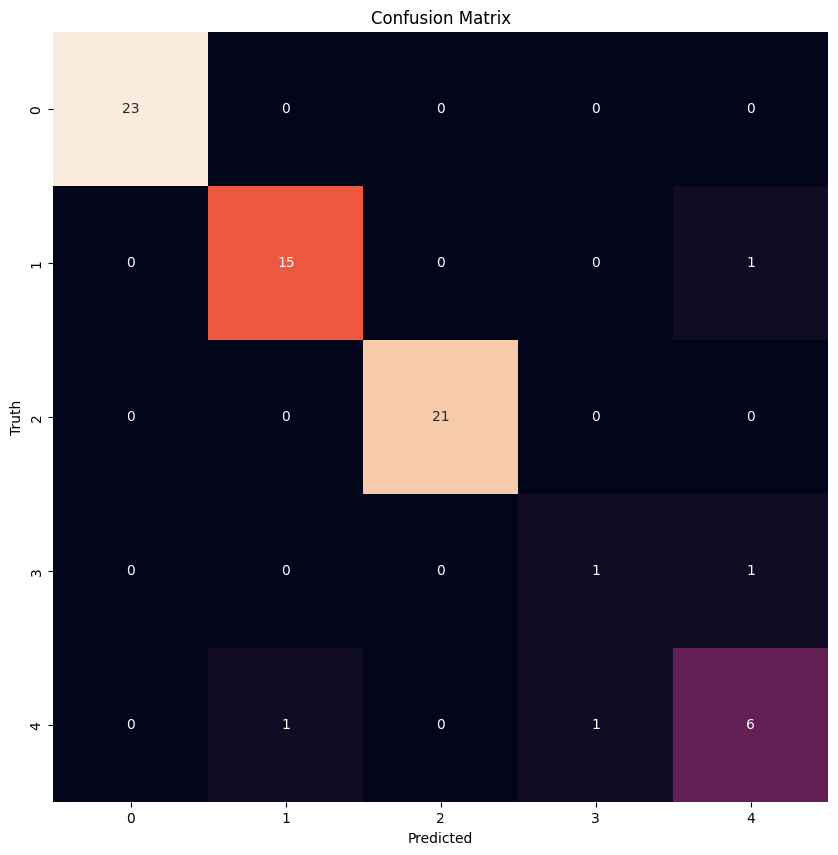

In [240]:
clf = DecisionTreeClassifier(criterion="gini")

clf.fit(X_train_selected, y_train_selected)

y_pred = clf.predict(X_test_selected)

prediction_evaluation(y_test_selected, y_pred)

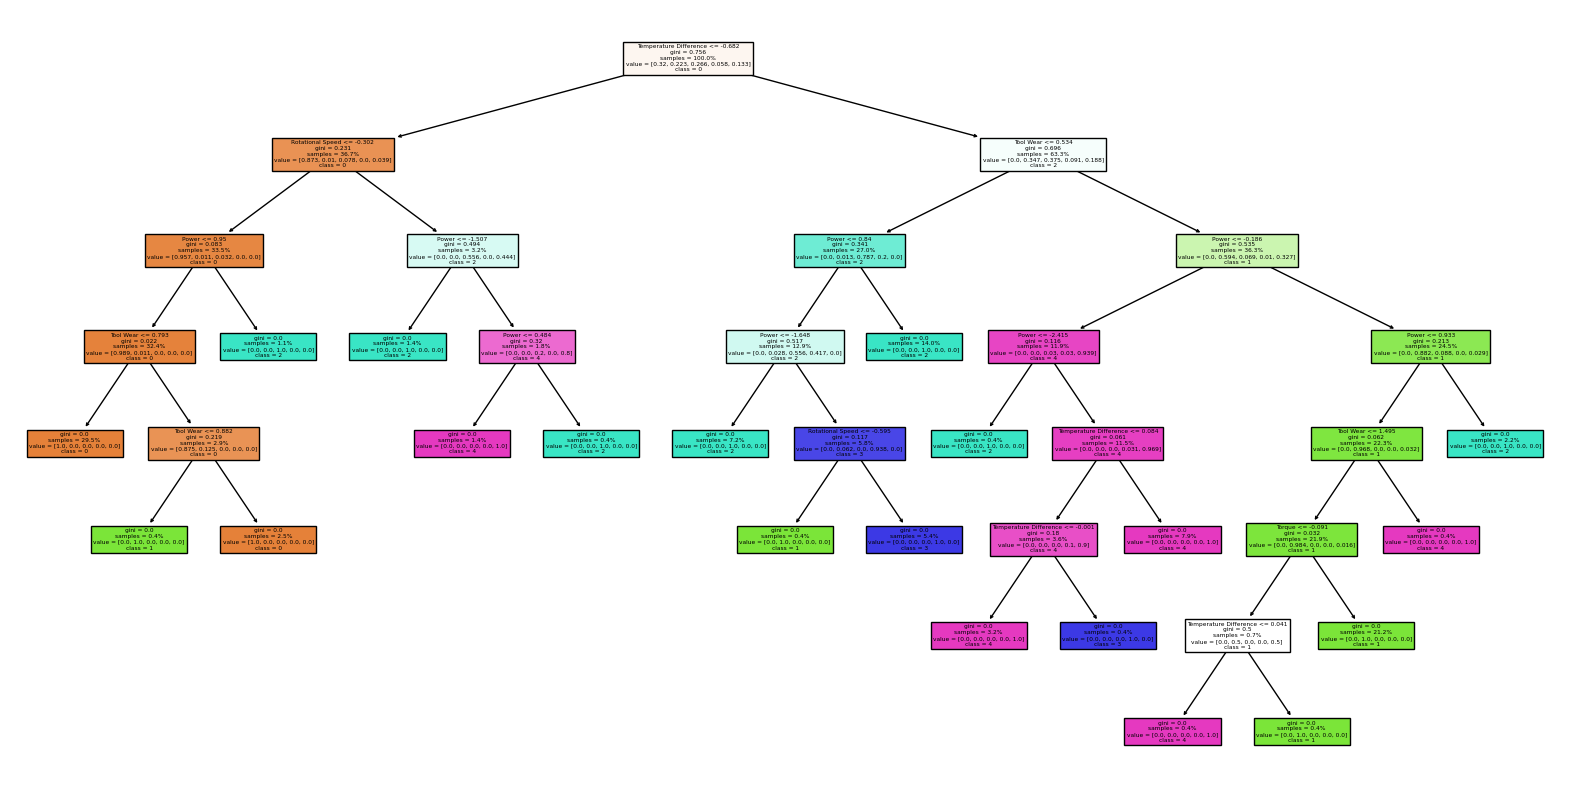

In [241]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_selected.columns, class_names=['0','1', '2', '3', '4'], proportion=True)
plt.show()

#### Fine Tuning

In [242]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(f"Migliori parametri: {grid_search.best_params_}")

Migliori parametri: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


Accuracy: 0.95714
Balanced Accuracy: 0.86250
MCC: 0.94193
Precision: 0.94306
Recall: 0.86250
F1: 0.88554


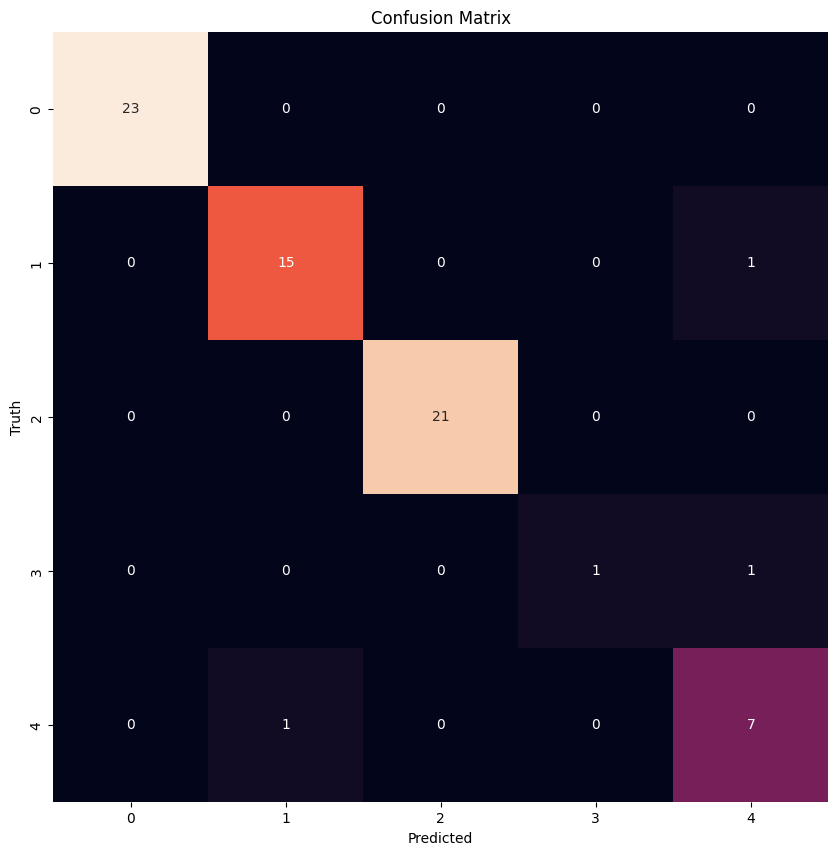

In [243]:
clf = DecisionTreeClassifier(**grid_search.best_params_)

clf.fit(X_train_selected, y_train_selected)

y_pred = clf.predict(X_test_selected)

prediction_evaluation(y_test_selected, y_pred)

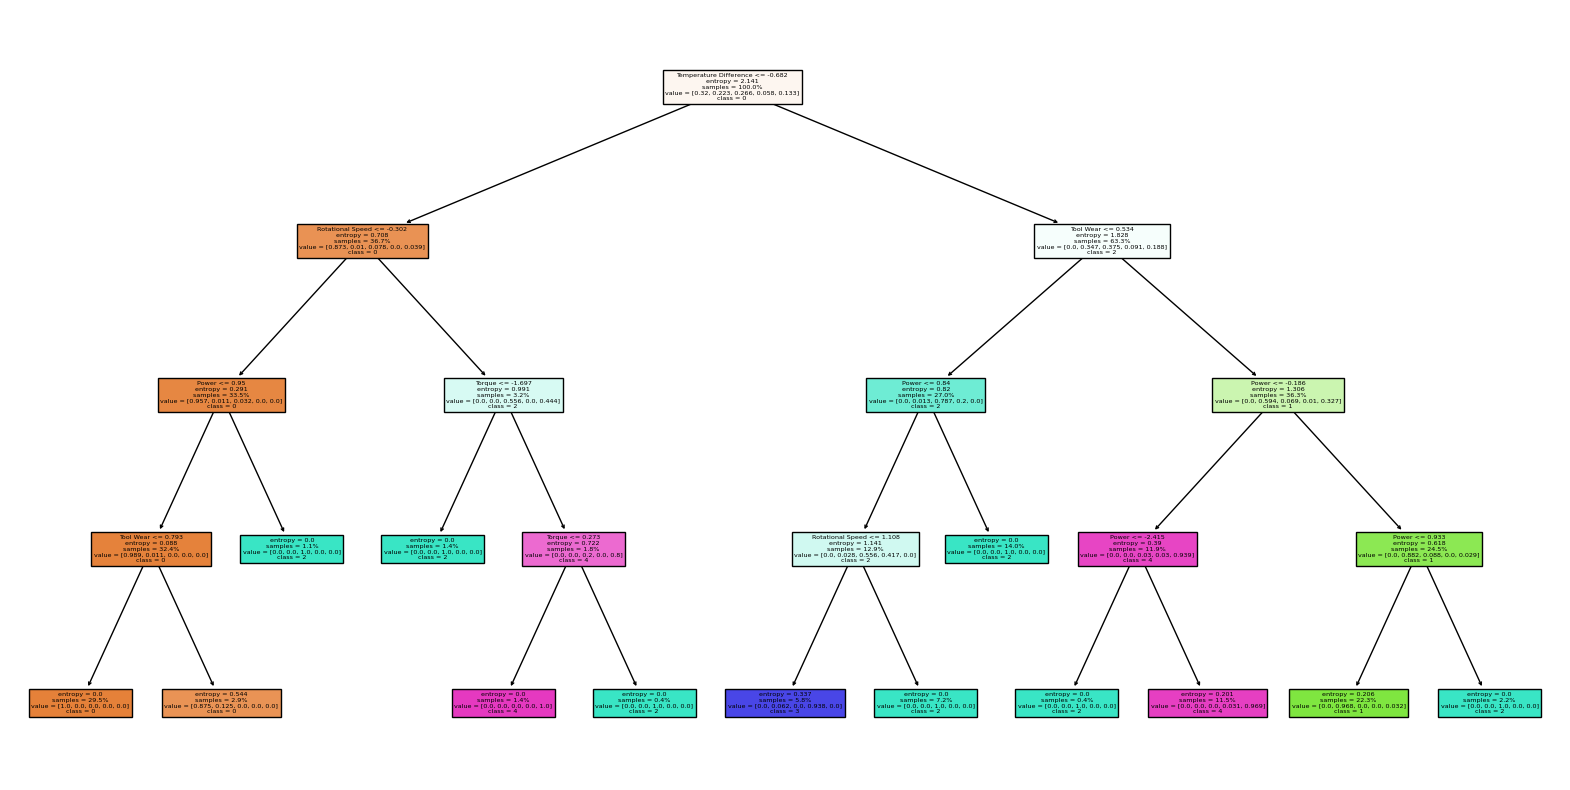

In [244]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train_selected.columns, class_names=['0','1', '2', '3', '4'], proportion=True)
plt.show()

### Clustering

Per prima cosa, non abbiamo necessità per questo caso di effettuare lo split del dataset in train e test, quindi lo processeremo nel seguente modo:

In [248]:
X['Type'].unique()

array(['L', 'M', 'H'], dtype=object)

In [249]:
order = ['L', 'M', 'H']

# Inizializza l'OrdinalEncoder
encoder = OrdinalEncoder(categories= [order])

# Adatta e trasforma i dati con l'OrdinalEncoder
X['Type'] = encoder.fit_transform(X[['Type']]).astype(int)

# Stampa i dati codificati
X

Type  Air Temperature  Process Temperature  Rotational Speed  Torque  \
50       0            298.9                309.1              2861     4.6   
69       0            298.9                309.0              1410    65.7   
77       0            298.8                308.9              1455    41.3   
160      0            298.4                308.2              1282    60.7   
161      0            298.3                308.1              1412    52.3   
...    ...              ...                  ...               ...     ...   
9758     0            298.6                309.8              2271    16.2   
9764     0            298.5                309.5              1294    66.7   
9822     0            298.5                309.4              1360    60.9   
9830     0            298.3                309.3              1337    56.1   
9974     0            298.6                308.2              1361    68.2   

      Tool Wear  Temperature Difference        Power  
50          143                    10.2  1378.174808  
69          191                    10.1  9700.923944  
77          208                    10.1  6292.767158  
160         216                     9.8  8149.019063  
161         218                     9.8  7733.302579  
...         ...                     ...          ...  
9758        218                    11.2  3852.660730  
9764         12                    11.0  9038.341110  
9822        187                    10.9  8673.308988  
9830        206                    11.0  7854.578528  
9974        172                     9.6  9720.108603  

[348 rows x 8 columns]

In [250]:
encoder = LabelEncoder()

# Addestra il LabelEncoder e trasforma le etichette di addestramento
y_array = encoder.fit_transform(y)

y = pd.Series(y_array, index=y.index, name=y.name)

In [251]:
scores, pvalues = chi2(X.drop('Type', axis=1), y)

print("Punteggi chi2: ", scores)
print("Valori p: ", pvalues)

selected_features = np.where(pvalues < 0.05)[0]
selected_features = [i+1 for i in selected_features]

X_selected = X.iloc[:, selected_features]

X_selected.insert(0, 'Type', X['Type'])

print("Caratteristiche selezionate: ", selected_features)
X = X_selected

Punteggi chi2:  [1.58290246e+00 1.56342318e-01 7.64653956e+03 2.56999017e+02
 6.19868763e+03 2.53543493e+01 1.83284262e+04]
Valori p:  [8.11861763e-01 9.97099291e-01 0.00000000e+00 2.02134601e-54
 0.00000000e+00 4.26942514e-05 0.00000000e+00]
Caratteristiche selezionate:  [3, 4, 5, 6, 7]


In [252]:
features_to_scale = ['Rotational Speed', 'Torque', 'Tool Wear', 'Temperature Difference', 'Power']

scaler = StandardScaler()
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

C:\Users\david\AppData\Local\Temp\ipykernel_9684\4217389958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features_to_scale] = scaler.fit_transform(X[features_to_scale])


In [253]:
X["Target"] = y

C:\Users\david\AppData\Local\Temp\ipykernel_9684\858881378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Target"] = y


<Axes: xlabel='Torque', ylabel='Rotational Speed'>

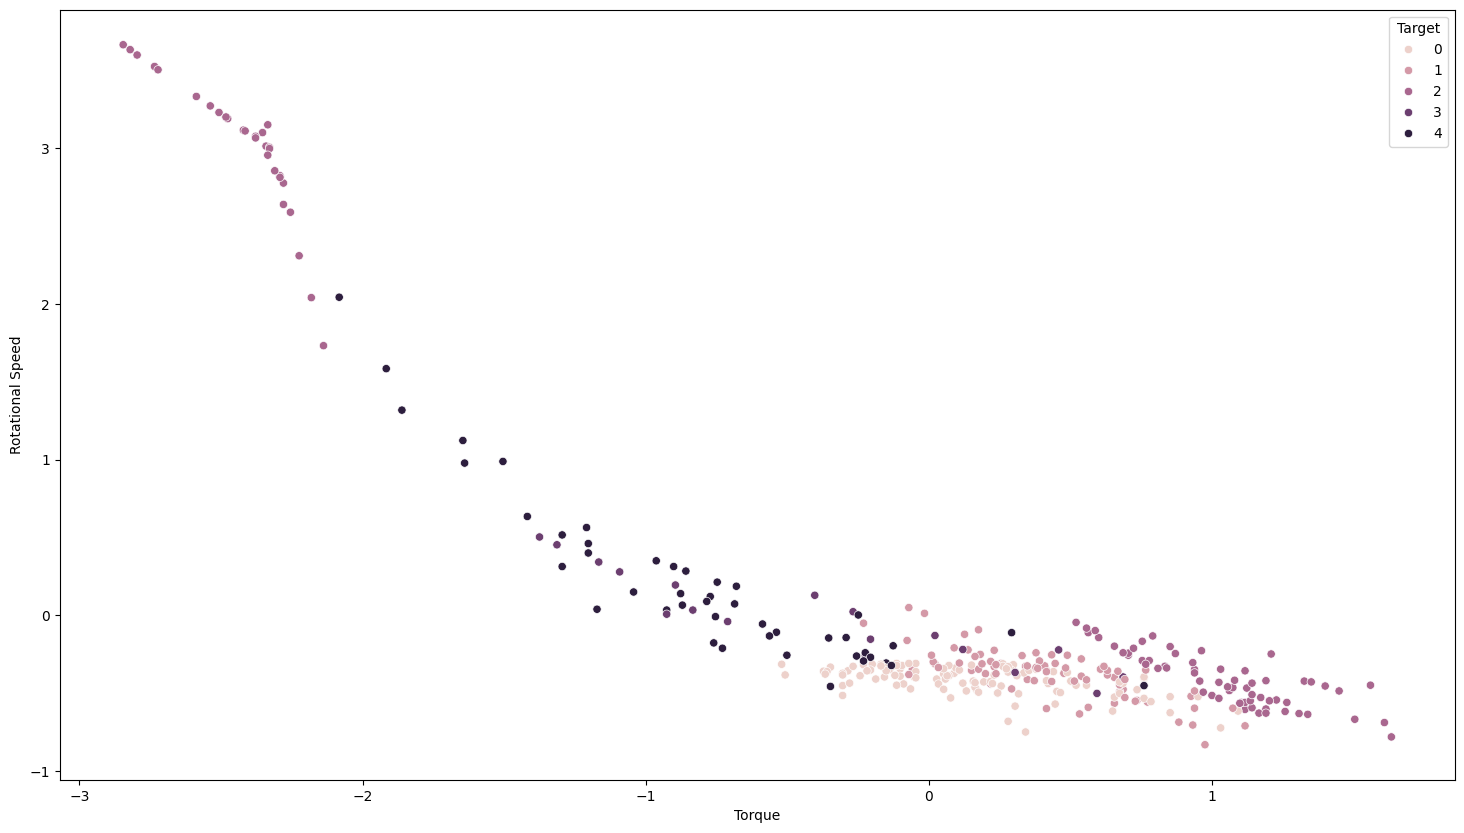

In [254]:
fig,ax = plt.subplots(figsize=(18, 10))

sns.scatterplot(x="Torque", y="Rotational Speed", hue="Target", data=X)

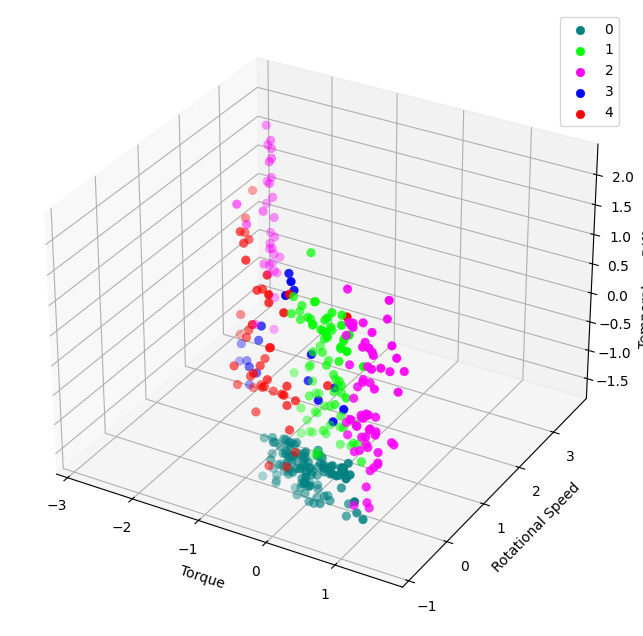

In [255]:
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X[X['Target'] == 0]['Torque'],
           ys=X[X['Target'] == 0]['Rotational Speed'],
           zs=X[X['Target'] == 0]['Temperature Difference'],
           s=40,edgecolor='teal', linewidth=0.2, c='teal', label='0')


ax.scatter(xs=X[X['Target'] == 1]['Torque'],
           ys=X[X['Target'] == 1]['Rotational Speed'],
           zs=X[X['Target'] == 1]['Temperature Difference'],
           s=40,edgecolor='lime', linewidth=0.2, c='lime', label='1')


ax.scatter(xs=X[X['Target'] == 2]['Torque'],
           ys=X[X['Target'] == 2]['Rotational Speed'],
           zs=X[X['Target'] == 2]['Temperature Difference'],
           s=40,edgecolor='magenta', linewidth=0.2, c='magenta', label='2')

ax.scatter(xs=X[X['Target'] == 3]['Torque'],
           ys=X[X['Target'] == 3]['Rotational Speed'],
           zs=X[X['Target'] == 3]['Temperature Difference'],
           s=40,edgecolor='blue', linewidth=0.2, c='blue', label='3')


ax.scatter(xs=X[X['Target'] == 4]['Torque'],
           ys=X[X['Target'] == 4]['Rotational Speed'],
           zs=X[X['Target'] == 4]['Temperature Difference'],
           s=40,edgecolor='red', linewidth=0.2, c='red', label='4')


ax.set_xlabel('Torque')
ax.set_ylabel('Rotational Speed')
ax.set_zlabel('Temperature Difference')


plt.legend(loc='upper right')
plt.show()

In questo tipo di analisi è utile appoggarsi all'uso e alla visualizzazione di una matrice di dissimilarità, ovvero una matrice che rappresenta le misure di dissimilarità tra un insieme di oggetti (nel nostro caso tra gli elementi del dataset). In questo caso, la misura di dissimilarità è la pairwise distance tra i punti del dataset, ovvero la distanza tra ogni possibile coppia di punti (come metrica di distanza adottiamo la distanza euclidea).

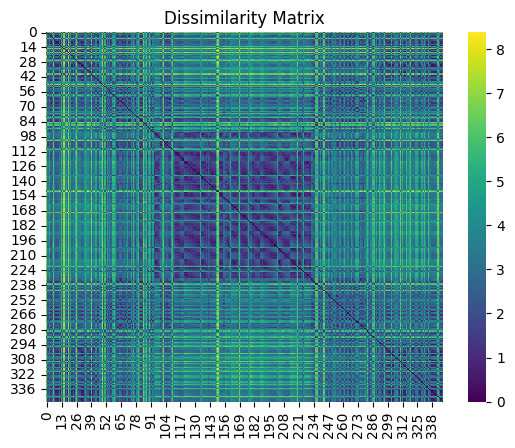

In [256]:
distances = pairwise_distances(X)
sns.heatmap(distances, cmap='viridis')
plt.title('Dissimilarity Matrix')
plt.show()

#### Inerzia

Dobbiamo ora valutare il numero di cluster da utilizzare per il clustering. Per farlo consideriamo un numero di cluster variabile pari a K ed analizziamo il valore dell'inerzia ottenuta creando un modello con il numero stabilito K di cluster.

L'inerzia misura quanto bene un set di dati è stato raggruppato per mezzo dell'algoritmo K-Means. Viene calcolato misurando la distanza tra ciascun punto e il relativo centroide, e sommando le i quadrati delle distanze.

∑i=0n||xj−μi||2

Un buon modello è quello con bassa inerzia e un ridotto numero di cluster (K). Tuttavia, questo è un compromesso perché all'aumentare di K, l'inerzia diminuisce.

Per trovare il K ottimale per un set di dati, si utilizza il metodo Elbow, che consiste nel trovare il punto in cui la diminuzione dell'inerzia inizia a rallentare.

c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

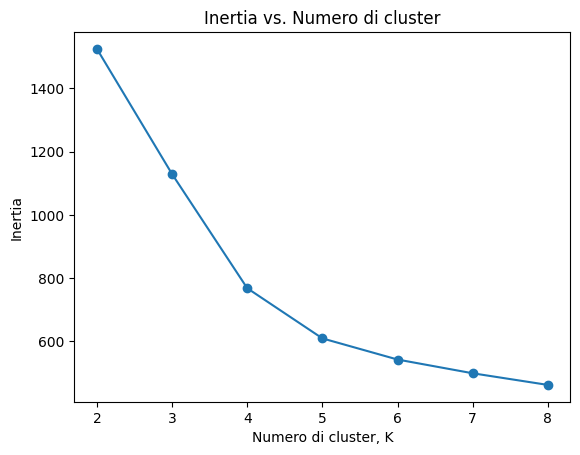

In [257]:
k_values = range(2, 9)
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, '-o')
plt.xlabel('Numero di cluster, K')
plt.ylabel('Inertia')
plt.title('Inertia vs. Numero di cluster')
plt.show()

In [258]:
X

Type  Rotational Speed    Torque  Tool Wear  Temperature Difference  \
50       0          3.596327 -2.796064  -0.003201                0.672457   
69       0         -0.226115  0.963304   0.656817                0.586009   
77       0         -0.107569 -0.537982   0.890573                0.586009   
160      0         -0.563312  0.655663   1.000576                0.326664   
161      0         -0.220846  0.138827   1.028077                0.326664   
...    ...               ...       ...        ...                     ...   
9758     0          2.042060 -2.082338   1.028077                1.536937   
9764     0         -0.531700  1.024832  -1.804498                1.364041   
9822     0         -0.357833  0.667969   0.601815                1.277593   
9830     0         -0.418423  0.372634   0.863072                1.364041   
9974     0         -0.355198  1.117124   0.395560                0.153768   

         Power  Target  
50   -3.208662       2  
69    1.321580       2  
77   -0.533549       4  
160   0.476846       1  
161   0.250564       1  
...        ...     ...  
9758 -1.861749       4  
9764  0.960923       2  
9822  0.762228       1  
9830  0.316576       1  
9974  1.332023       2  

[348 rows x 7 columns]

Dal grafico si evince che un buon valore K di cluster da utilizzare sia in un range tra 5 e 8. Considerando che il nostro target ha 5 diversi possibili valori, possiamo considerare un valore di K=5.

Prendiamo dal dataset di partenza un'istanza per ogni valore possibile del target. Useremo i 6 punti estratti come centroidi iniziali per il modello K-means che andremo ad allenare.

In [259]:
punti_casuali = X.groupby('Target', observed= False).apply(lambda x: x.sample(n=1, random_state=0))

print(punti_casuali.drop('Target', axis=1).values)
X.drop('Target', axis=1, inplace=True)

[[ 0.         -0.35256382  0.29264755  0.16180383 -0.97005671  0.29559438]
 [ 0.         -0.30777987  0.44646786  0.83557159  0.0673202   0.54520788]
 [ 0.         -0.16552498  0.75410847 -1.69449509  0.4131125   1.12999352]
 [ 0.          0.02414821 -0.26725836  0.01054985  1.53693748 -0.03838074]
 [ 0.          0.40086023 -1.20248582  1.0143263   0.24021635 -1.09372752]]


C:\Users\david\AppData\Local\Temp\ipykernel_9684\2650554998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('Target', axis=1, inplace=True)


In [260]:
start = time.time()
kms = KMeans(n_clusters=5, init=punti_casuali.drop('Target', axis=1).values)
kms.fit(X)
end = time.time()
print(end-start)

clusters = X.copy()
clusters['Cluster_Prediction'] = kms.fit_predict(X)
clusters.head()

0.00848531723022461


c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: RuntimeWa

Type  Rotational Speed    Torque  Tool Wear  Temperature Difference  \
50      0          3.596327 -2.796064  -0.003201                0.672457   
69      0         -0.226115  0.963304   0.656817                0.586009   
77      0         -0.107569 -0.537982   0.890573                0.586009   
160     0         -0.563312  0.655663   1.000576                0.326664   
161     0         -0.220846  0.138827   1.028077                0.326664   

        Power  Cluster_Prediction  
50  -3.208662                   4  
69   1.321580                   1  
77  -0.533549                   3  
160  0.476846                   1  
161  0.250564                   1

In [261]:
kms.labels_

array([4, 1, 3, 1, 1, 2, 4, 2, 1, 1, 1, 2, 3, 4, 2, 4, 3, 2, 3, 4, 2, 4,
       1, 2, 3, 3, 4, 2, 2, 2, 1, 3, 3, 3, 4, 3, 2, 3, 3, 4, 3, 1, 1, 3,
       1, 3, 3, 3, 3, 4, 2, 4, 1, 3, 2, 3, 1, 2, 3, 4, 3, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 4, 2, 1, 0, 4, 0, 1, 1, 1, 4, 0, 4,
       1, 3, 4, 1, 1, 3, 0, 0, 0, 0, 0, 0, 1, 3, 4, 1, 1, 1, 1, 1, 1, 3,
       4, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 4, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 4, 4, 1, 1, 3, 1,
       1, 4, 1, 1, 3, 1, 1, 1, 3, 2, 2, 0, 1, 2, 1, 3, 2, 1, 1, 3, 2, 1,
       2, 1, 1, 3, 2, 1, 1, 3, 3, 3, 1, 2, 2, 2, 1, 2, 3, 4, 3, 3, 2, 2,
       4, 4, 1, 3, 1, 2, 3, 3, 3, 3, 4, 2, 2, 1, 1,

Notiamo che i cluster ottenuti non sono allineati con le etichette del target del nostro dataset. Sarà dunque necessario effettuare un'operazione di riassegnazione delle etichette per allinearle correttamente. Il riassegnamento delle etichette si basa sulla distanza tra le etichette stesse e viene effettuato tramite l'algoritmo del nearest neighbor.

In [262]:
clust_pred = clusters["Cluster_Prediction"].unique()
y_pred = y.unique()

# Esempio di coordinate delle etichette
coordinate1 = np.array(X.values)
coordinate2 = np.array(clusters.drop('Cluster_Prediction', axis=1).values)

# Calcolo della matrice delle distanze
distanze = distance.cdist(coordinate1, coordinate2, metric='euclidean')

# Allineamento delle etichette basato sulla distanza
allineamento = []
for i in range(len(y_pred)):
    indice_min = np.argmin(distanze[i])
    etichetta1 = y_pred[i]
    etichetta2 = clust_pred[indice_min]
    allineamento.append((etichetta1, etichetta2))

print(allineamento)

[(2, 4), (4, 1), (1, 3), (3, 2), (0, 0)]


Riassegnamo quindi le etichette ottenute dall'algoritmo di clustering in modo da allinearle con le etichette del target del dataset, usando la mappa generata nello script precedente.

In [263]:
mappatura_etichette = {
    allineamento[0][1]: allineamento[0][0],
    allineamento[1][1]: allineamento[1][0],
    allineamento[2][1]: allineamento[2][0],
    allineamento[3][1]: allineamento[3][0],
    allineamento[4][1]: allineamento[4][0],
}
clusters = clusters.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
clusters["Cluster_Prediction"]
kms.labels_ = clusters["Cluster_Prediction"].values
kms.labels_

array([2, 4, 1, 4, 4, 3, 2, 3, 4, 4, 4, 3, 1, 2, 3, 2, 1, 3, 1, 2, 3, 2,
       4, 3, 1, 1, 2, 3, 3, 3, 4, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 4, 4, 1,
       4, 1, 1, 1, 1, 2, 3, 2, 4, 1, 3, 1, 4, 3, 1, 2, 1, 4, 4, 4, 3, 3,
       4, 4, 4, 4, 3, 1, 4, 4, 4, 3, 2, 3, 4, 0, 2, 0, 4, 4, 4, 2, 0, 2,
       4, 1, 2, 4, 4, 1, 0, 0, 0, 0, 0, 0, 4, 1, 2, 4, 4, 4, 4, 4, 4, 1,
       2, 3, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 2, 2, 4, 4, 1, 4,
       4, 2, 4, 4, 1, 4, 4, 4, 1, 3, 3, 0, 4, 3, 4, 1, 3, 4, 4, 1, 3, 4,
       3, 4, 4, 1, 3, 4, 4, 1, 1, 1, 4, 3, 3, 3, 4, 3, 1, 2, 1, 1, 3, 3,
       2, 2, 4, 1, 4, 3, 1, 1, 1, 1, 2, 3, 3, 4, 4,

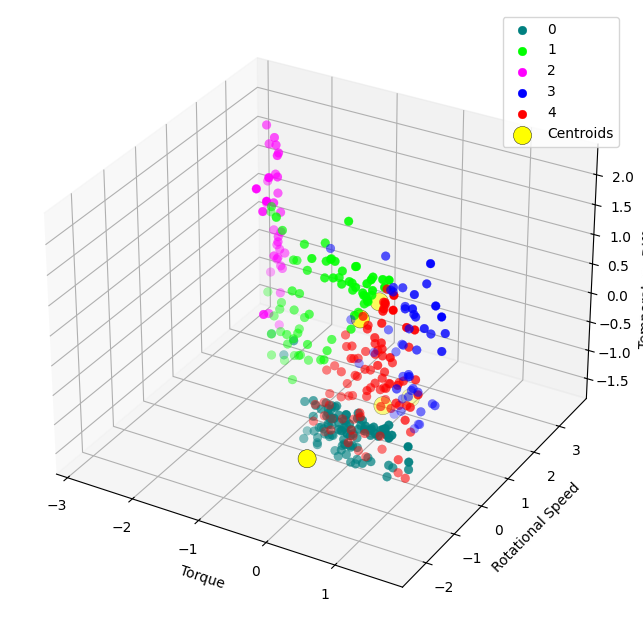

In [264]:
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 0]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 0]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 0]['Temperature Difference'],
           s=40,edgecolor='teal', linewidth=0.2, c='teal', label='0')


ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 1]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 1]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 1]['Temperature Difference'],
           s=40,edgecolor='lime', linewidth=0.2, c='lime', label='1')


ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 2]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 2]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 2]['Temperature Difference'],
           s=40,edgecolor='magenta', linewidth=0.2, c='magenta', label='2')

ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 3]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 3]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 3]['Temperature Difference'],
           s=40,edgecolor='blue', linewidth=0.2, c='blue', label='3')


ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 4]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 4]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 4]['Temperature Difference'],
           s=40,edgecolor='red', linewidth=0.2, c='red', label='4')


ax.scatter(kms.cluster_centers_[:, 0], kms.cluster_centers_[:, 2], kms.cluster_centers_[:, 3], s = 170, c = 'yellow', label = 'Centroids',edgecolor='black', linewidth=0.3)

ax.set_xlabel('Torque')
ax.set_ylabel('Rotational Speed')
ax.set_zlabel('Temperature Difference')

plt.legend(loc='upper right')
plt.show()

In [265]:
nmi = normalized_mutual_info_score(y, kms.labels_)
print("NMI (Normalized Mutual Information): %0.5f" % (nmi))

rand_index = adjusted_rand_score(y, kms.labels_)
print("Indice di Rand: %0.5f" % (rand_index))

jaccard_index = jaccard_score(y, kms.labels_, average='macro')
print("Indice di Jaccard: %0.5f" % (jaccard_index))

precision = precision_score(y, kms.labels_, average='macro')
recall = recall_score(y, kms.labels_, average='macro')
f1 = f1_score(y, kms.labels_, average='macro')

print("Precisione: %0.5f" % (precision))
print("Richiamo: %0.5f" % (recall))
print("Punteggio F1: %0.5f" % (f1))

NMI (Normalized Mutual Information): 0.51266
Indice di Rand: 0.45640
Indice di Jaccard: 0.28993
Precisione: 0.47693
Richiamo: 0.37859
Punteggio F1: 0.39092


#### Silhouette

Oltre all'inerzia, che però è soggetta a diminuire in funzione dell'aumentare del numero di cluster, per validare un metodo di clustering si possono solitamente utilizzare due criteri: la distanza intercluster e la distanza intracluster.

E di conseguenza unire il tutto all'interno della misura Silhouette:
Silhouette(x)=b(x)−a(x)max(b(x),a(x))
dove:
- a(x) è la distanza media tra x e tutti gli altri punti all'interno del cluster
- b(x) è il minimo delle distanze medie tra x e i punti negli altri cluster

For n_clusters = 3 The average silhouette_score is : 0.30527805340598746
For n_clusters = 4 The average silhouette_score is : 0.29551135651389737
For n_clusters = 5 The average silhouette_score is : 0.29683005734784623
For n_clusters = 6 The average silhouette_score is : 0.3120926051016298
For n_clusters = 7 The average silhouette_score is : 0.2919259037656651
For n_clusters = 8 The average silhouette_score is : 0.3026925655171955


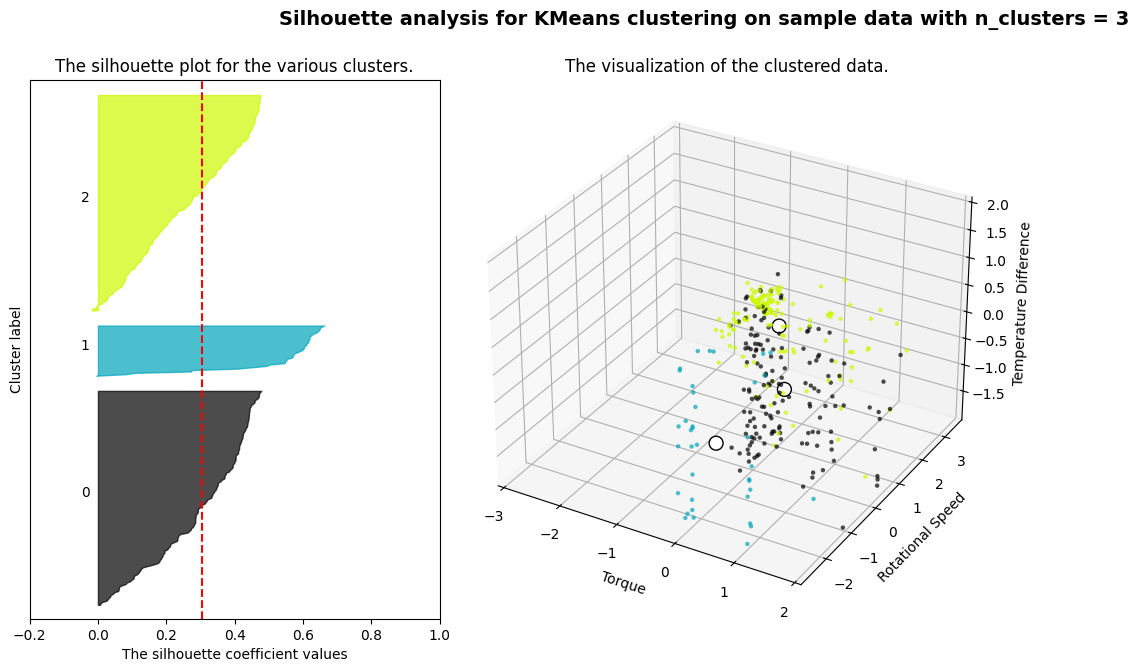

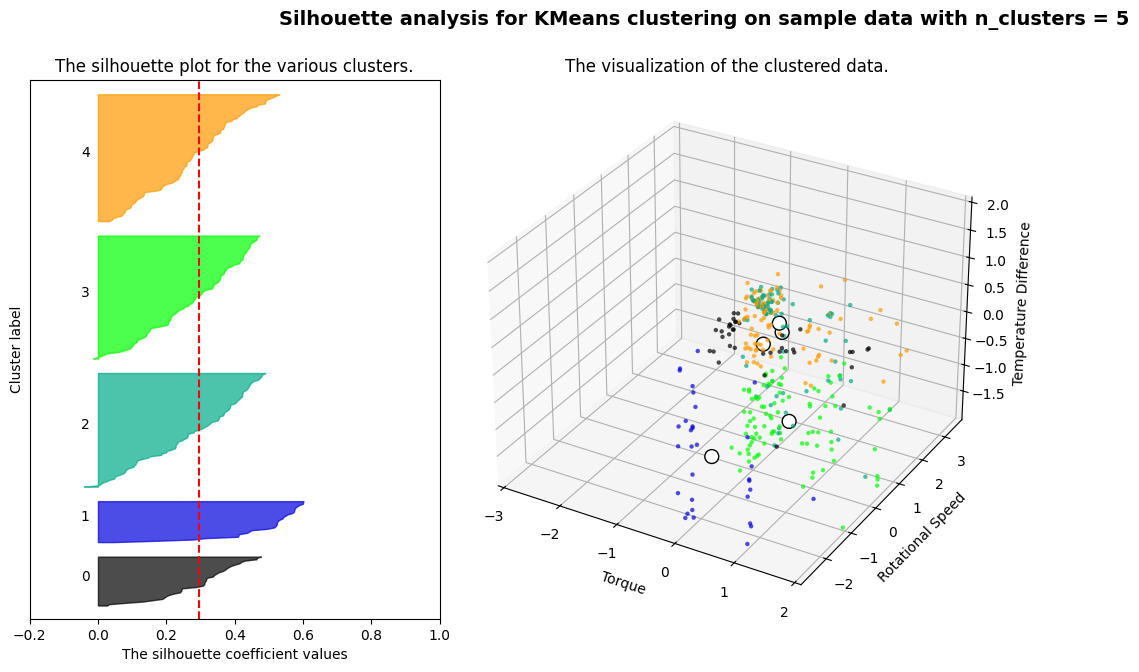

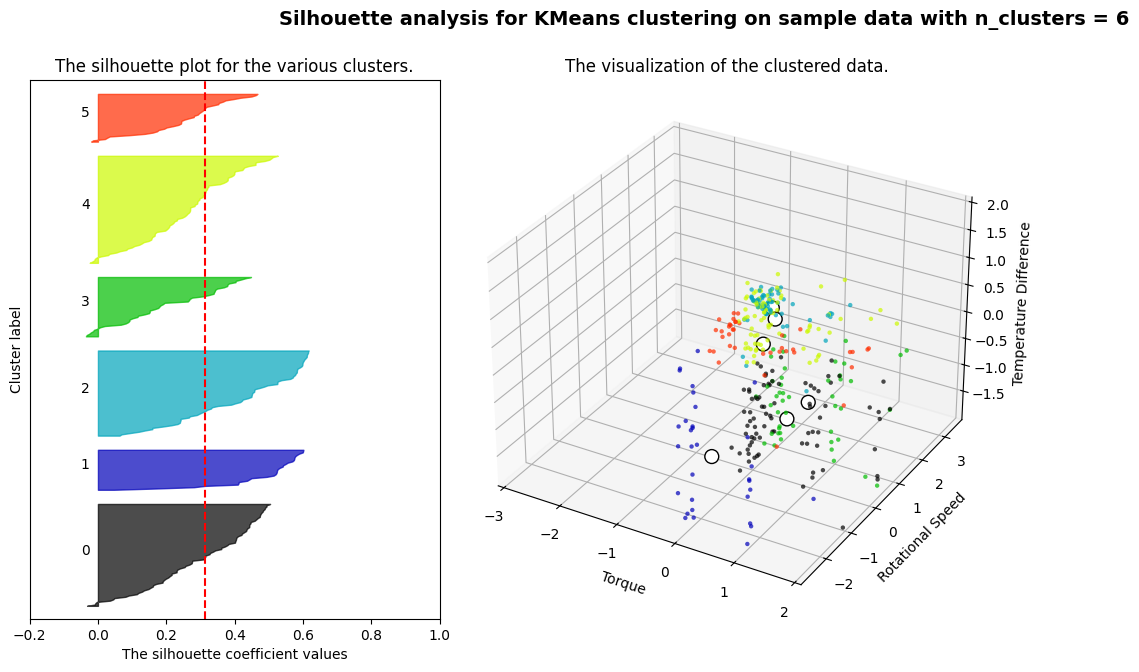

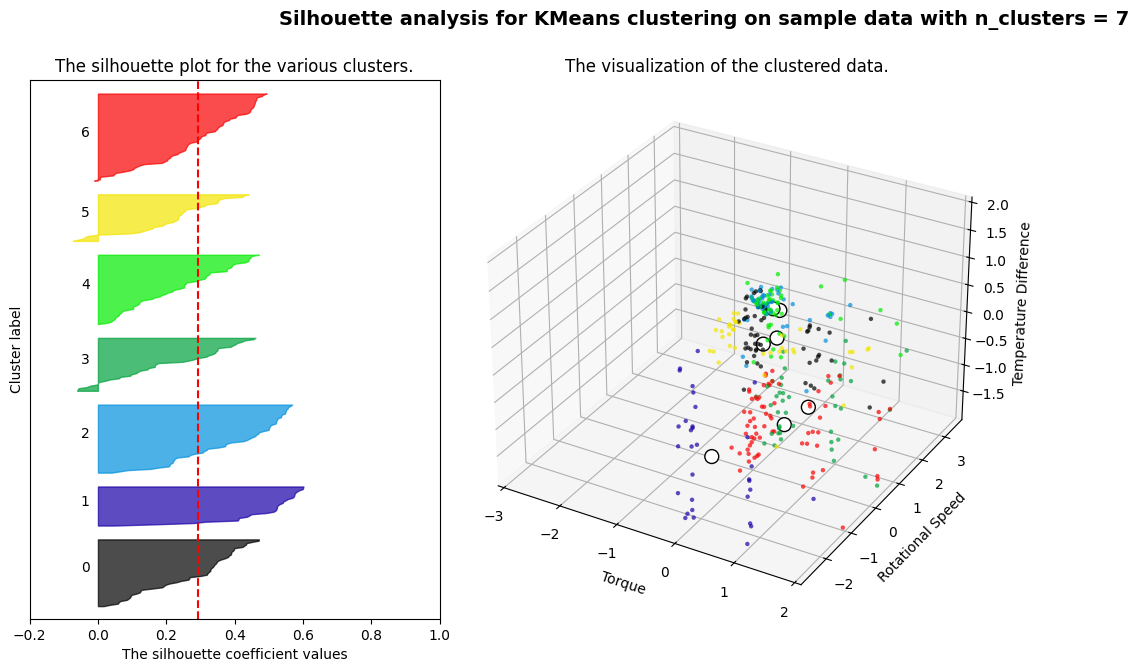

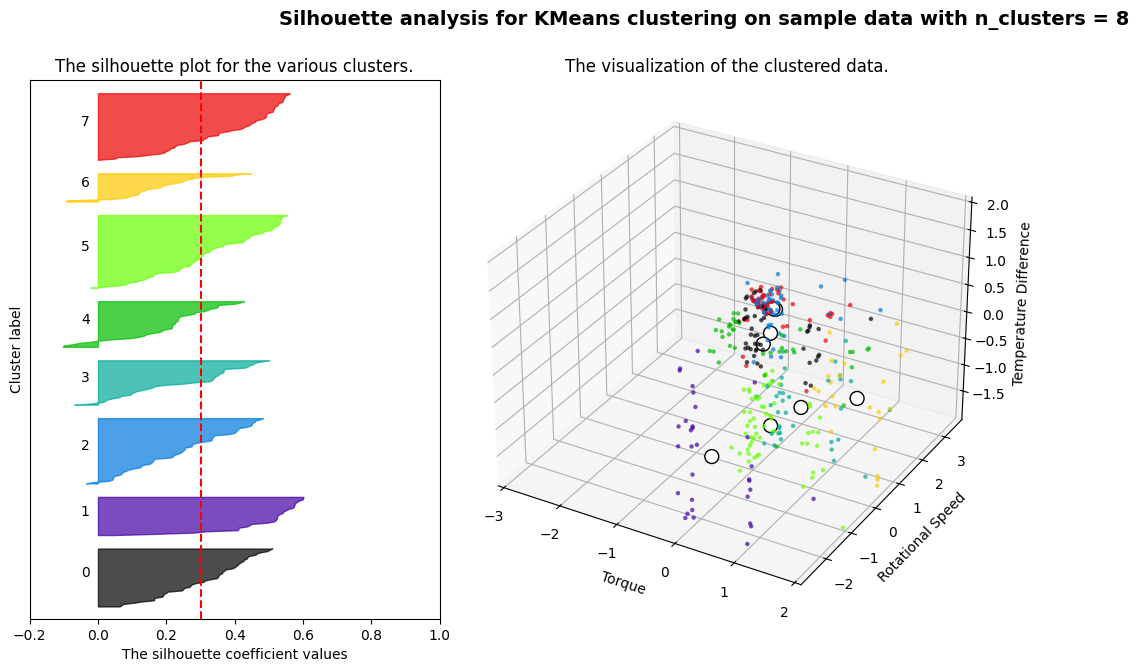

In [266]:
range_n_clusters = [3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(111, projection='3d')
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.set_xlim([min(X.iloc[:, 0]) - 3, max(X.iloc[:, 0])])
    ax2.set_ylim([min(X.iloc[:, 2]), max(X.iloc[:, 2]) + 2])
    ax2.set_zlim([min(X.iloc[:, 3]), max(X.iloc[:, 3]) + 0.5])
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 2], X.iloc[:, 3], marker=".", s=40, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 2],
        centers[:, 3],
        marker="o",
        c="white",
        alpha=1,
        s=100,
        edgecolor="k",
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Torque")
    ax2.set_ylabel("Rotational Speed")
    ax2.set_zlabel("Temperature Difference")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### Spectral Clustering

In [267]:
start = time.time()
sc = SpectralClustering(n_clusters=6, affinity="nearest_neighbors", n_init=10, random_state=42)
sc.fit(X)
end = time.time()
print(end-start)

clusters = X.copy()
clusters['Cluster_Prediction'] = sc.fit_predict(X)
sc.labels_

0.10587024688720703


array([3, 4, 0, 1, 1, 4, 3, 4, 1, 1, 1, 4, 0, 3, 4, 3, 0, 4, 0, 3, 4, 3,
       0, 4, 0, 2, 3, 4, 4, 4, 0, 0, 0, 0, 3, 0, 4, 0, 0, 3, 0, 4, 4, 0,
       1, 1, 2, 2, 2, 3, 4, 3, 1, 2, 4, 2, 1, 4, 2, 3, 2, 1, 1, 1, 4, 4,
       1, 1, 1, 1, 4, 2, 1, 1, 2, 4, 2, 2, 1, 2, 3, 2, 1, 1, 1, 3, 2, 3,
       1, 2, 3, 1, 1, 2, 1, 5, 5, 2, 2, 2, 1, 2, 3, 1, 2, 1, 1, 2, 1, 2,
       3, 4, 2, 5, 5, 5, 1, 1, 1, 2, 2, 5, 5, 5, 2, 2, 5, 5, 5, 2, 2, 1,
       1, 1, 1, 2, 5, 5, 5, 5, 2, 2, 5, 2, 1, 1, 1, 2, 1, 3, 3, 5, 5, 5,
       5, 2, 2, 2, 2, 1, 1, 1, 2, 2, 5, 5, 5, 2, 5, 3, 5, 2, 1, 1, 1, 2,
       1, 1, 5, 2, 5, 5, 5, 2, 2, 1, 1, 2, 5, 2, 5, 5, 5, 5, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 5, 5, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 5, 5, 5, 5, 2,
       3, 5, 5, 2, 1, 2, 5, 5, 5, 5, 2, 5, 4, 4, 1, 1, 3, 3, 2, 1, 2, 1,
       2, 3, 1, 2, 1, 1, 1, 1, 2, 4, 2, 5, 1, 4, 1, 2, 4, 1, 2, 2, 4, 1,
       4, 1, 1, 2, 4, 1, 1, 2, 2, 2, 1, 4, 4, 2, 1, 4, 1, 3, 0, 0, 4, 4,
       3, 3, 1, 2, 1, 4, 0, 0, 0, 0, 3, 4, 4, 4, 4,

In [268]:
clust_pred = clusters["Cluster_Prediction"].unique()
y_pred = y.unique()

# Esempio di coordinate delle etichette
coordinate1 = np.array(X.values)
coordinate2 = np.array(clusters.drop('Cluster_Prediction', axis=1).values)

# Calcolo della matrice delle distanze
distanze = distance.cdist(coordinate1, coordinate2, metric='euclidean')

# Allineamento delle etichette basato sulla distanza
allineamento = []
for i in range(len(y_pred)):
    indice_min = np.argmin(distanze[i])
    etichetta1 = y_pred[i]
    etichetta2 = clust_pred[indice_min]
    allineamento.append((etichetta1, etichetta2))

print(allineamento)

[(2, 3), (4, 4), (1, 0), (3, 1), (0, 2)]


In [269]:
mappatura_etichette = {
    allineamento[0][1]: allineamento[0][0],
    allineamento[1][1]: allineamento[1][0],
    allineamento[2][1]: allineamento[2][0],
    allineamento[3][1]: allineamento[3][0],
    allineamento[4][1]: allineamento[4][0]
}
clusters = clusters.applymap(lambda x: mappatura_etichette[x] if x in mappatura_etichette else x)
clusters["Cluster_Prediction"]
sc.labels_ = clusters["Cluster_Prediction"].values
sc.labels_

array([2, 4, 1, 3, 3, 4, 2, 4, 3, 3, 3, 4, 1, 2, 4, 2, 1, 4, 1, 2, 4, 2,
       1, 4, 1, 0, 2, 4, 4, 4, 1, 1, 1, 1, 2, 1, 4, 1, 1, 2, 1, 4, 4, 1,
       3, 3, 0, 0, 0, 2, 4, 2, 3, 0, 4, 0, 3, 4, 0, 2, 0, 3, 3, 3, 4, 4,
       3, 3, 3, 3, 4, 0, 3, 3, 0, 4, 0, 0, 3, 0, 2, 0, 3, 3, 3, 2, 0, 2,
       3, 0, 2, 3, 3, 0, 3, 5, 5, 0, 0, 0, 3, 0, 2, 3, 0, 3, 3, 0, 3, 0,
       2, 4, 0, 5, 5, 5, 3, 3, 3, 0, 0, 5, 5, 5, 0, 0, 5, 5, 5, 0, 0, 3,
       3, 3, 3, 0, 5, 5, 5, 5, 0, 0, 5, 0, 3, 3, 3, 0, 3, 2, 2, 5, 5, 5,
       5, 0, 0, 0, 0, 3, 3, 3, 0, 0, 5, 5, 5, 0, 5, 2, 5, 0, 3, 3, 3, 0,
       3, 3, 5, 0, 5, 5, 5, 0, 0, 3, 3, 0, 5, 0, 5, 5, 5, 5, 0, 3, 0, 3,
       3, 0, 3, 3, 3, 5, 5, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 5, 5, 5, 5, 0,
       2, 5, 5, 0, 3, 0, 5, 5, 5, 5, 0, 5, 4, 4, 3, 3, 2, 2, 0, 3, 0, 3,
       0, 2, 3, 0, 3, 3, 3, 3, 0, 4, 0, 5, 3, 4, 3, 0, 4, 3, 0, 0, 4, 3,
       4, 3, 3, 0, 4, 3, 3, 0, 0, 0, 3, 4, 4, 0, 3, 4, 3, 2, 1, 1, 4, 4,
       2, 2, 3, 0, 3, 4, 1, 1, 1, 1, 2, 4, 4, 4, 4,

In [270]:
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 0]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 0]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 0]['Temperature Difference'],
           s=40,edgecolor='teal', linewidth=0.2, c='teal', label='0')


ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 1]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 1]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 1]['Temperature Difference'],
           s=40,edgecolor='lime', linewidth=0.2, c='lime', label='1')


ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 2]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 2]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 2]['Temperature Difference'],
           s=40,edgecolor='magenta', linewidth=0.2, c='magenta', label='2')

ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 3]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 3]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 3]['Temperature Difference'],
           s=40,edgecolor='blue', linewidth=0.2, c='blue', label='3')


ax.scatter(xs=clusters[clusters['Cluster_Prediction'] == 4]['Torque'],
           ys=clusters[clusters['Cluster_Prediction'] == 4]['Rotational Speed'],
           zs=clusters[clusters['Cluster_Prediction'] == 4]['Temperature Difference'],
           s=40,edgecolor='red', linewidth=0.2, c='red', label='4')


ax.set_xlabel('Torque')
ax.set_ylabel('Rotational Speed')
ax.set_zlabel('Temperature Difference')


plt.legend(loc='upper right')
plt.show()

In [271]:
nmi = normalized_mutual_info_score(y, sc.labels_)
print("NMI (Normalized Mutual Information): %0.5f" % (nmi))

rand_index = adjusted_rand_score(y, sc.labels_)
print("Indice di Rand: %0.5f" % (rand_index))

jaccard_index = jaccard_score(y, sc.labels_, average='macro')
print("Indice di Jaccard: %0.5f" % (jaccard_index))

precision = precision_score(y, sc.labels_, average='macro')
recall = recall_score(y, sc.labels_, average='macro')
f1 = f1_score(y, sc.labels_, average='macro')

print("Precisione: %0.5f" % (precision))
print("Richiamo: %0.5f" % (recall))
print("Punteggio F1: %0.5f" % (f1))

NMI (Normalized Mutual Information): 0.38848
Indice di Rand: 0.25898
Indice di Jaccard: 0.16000
Precisione: 0.36155
Richiamo: 0.21293
Punteggio F1: 0.24689
Il punteggio medio del silhouette è : 0.24825189004177423


c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
